# Loading and preprocessing input data

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score
import json
import os
from scipy.interpolate import interp1d
import mysql.connector
from pycaret.classification import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, GRU, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

from scipy.fftpack import dct
from scipy.signal import correlate
import pickle

In [23]:
dfs = []

In [24]:
# IMPORT FILE
json_file_path = 'data/database/mobile-sensor-reading_acce_gyro_magnet_grav_linAcce_relOri_absOri.json'

df = pd.read_json(json_file_path)

# Výpis aktivít s jednotlivými časmi
df_sum = pd.concat([df['activity'].value_counts(), df.groupby('activity')['elapsedTime'].sum()/1000], axis=1)

print(df_sum)
print(f"\n")

              count  elapsedTime
activity                        
"walk"          180     8551.019
"car"           161     6760.332
"train"         138     5525.621
"tram"          126     6733.478
"lie"           121     4565.868
"sit"           109     4577.674
"stand"          97     4098.864
"bus"            86     5006.511
"ontable"        84    26500.238
"stairsUp"       61     1904.343
"stairsDown"     55     1826.211
"metro"          36     1901.172
"other"          23      669.376
"run"             6      164.115




In [25]:
first_row_df = df.iloc[[1]]

# Extrakcia Katikých dát do môjho formátu

sensors = ['acce', 'gyro', 'magnet', 'absOri', 'relOri']
for index, row in df.iterrows():
    if(all(sensor in row['sensorData'] for sensor in sensors)):
        striped_activity = row['activity'].strip('\"')
        row.to_json(f"data/parsed_activities/{striped_activity}_{index}_data.json", orient='records', lines=False)
    else:
        continue

In [26]:
df2 = pd.read_json('data/first_row.json')


# Zoznam všetkých JSON súborov v adresári
json_files = [f for f in os.listdir('data/parsed_activities') if f.endswith('.json')]
json_files

# Iterovanie cez všetky JSON súbory a načítanie ich do DataFrame
for file in json_files:
    df_to_insert = pd.DataFrame(columns=['Activity', 'AcceExtractedData', 'GyroExtractedData', 'MagnetExtractedData', 'AbsoluteOrientationExtractedData', 'RelativeOrientatioExtractedData'])

    file_path = os.path.join('data/parsed_activities', file)  # Absolútna cesta k súboru
    file_df = pd.read_json(file_path)

    df_to_insert['Activity'] = file_df.iloc[0]

    df_to_insert['AcceExtractedData'] = file_df.iloc[2].apply(lambda x: x['acce'])
    df_to_insert['GyroExtractedData'] = file_df.iloc[2].apply(lambda x: x['gyro'])
    df_to_insert['MagnetExtractedData'] = file_df.iloc[2].apply(lambda x: x['magnet'])
    df_to_insert['AbsoluteOrientationExtractedData'] = file_df.iloc[2].apply(lambda x: x['absOri'])
    df_to_insert['RelativeOrientatioExtractedData'] = file_df.iloc[2].apply(lambda x: x['relOri'])

    dfs.append(df_to_insert)
    print('done ' + file)



# df_stats = df2.concat([df2['activity'], df2['elapsedTime']], axis=1)
# df_stats

done bus_1013_data.json
done bus_1015_data.json
done bus_1017_data.json
done bus_1068_data.json
done bus_1069_data.json
done bus_1070_data.json
done bus_1078_data.json
done bus_1079_data.json
done bus_1081_data.json
done bus_1086_data.json
done bus_1161_data.json
done bus_1162_data.json
done bus_1215_data.json
done bus_1216_data.json
done bus_1265_data.json
done bus_1267_data.json
done bus_492_data.json
done bus_493_data.json
done bus_494_data.json
done bus_501_data.json
done bus_502_data.json
done bus_503_data.json
done bus_504_data.json
done bus_505_data.json
done bus_506_data.json
done bus_507_data.json
done bus_775_data.json
done bus_776_data.json
done bus_777_data.json
done bus_778_data.json
done bus_779_data.json
done bus_782_data.json
done bus_783_data.json
done bus_784_data.json
done bus_785_data.json
done bus_786_data.json
done bus_787_data.json
done bus_788_data.json
done bus_792_data.json
done bus_793_data.json
done bus_794_data.json
done bus_795_data.json
done bus_796_data.

In [27]:
from collections import defaultdict

# Výpis dĺžky meraní mojich dátových súborov

json_files = [f for f in os.listdir('data/my_data') if f.endswith('.json')]

activity_durations = defaultdict(float)

for filename in json_files:
    filepath = os.path.join('data/my_data', filename)
    
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    activity = data['activity']
    
    t_values = [
        item['t'] for item in data['sensorData']['accelerometer'] 
        if item['t'] is not None
    ]
    
    if t_values:
        duration = max(t_values) - min(t_values)
        activity_durations[activity] += duration

for activity, total_duration in activity_durations.items():
    print(f"Aktivita: {activity}, dĺžka všetkých meraní: {total_duration / 1000} sekúnd")

Aktivita: tram, dĺžka všetkých meraní: 1575.695 sekúnd
Aktivita: walk, dĺžka všetkých meraní: 5025.806 sekúnd
Aktivita: sit, dĺžka všetkých meraní: 4281.43 sekúnd
Aktivita: ontable, dĺžka všetkých meraní: 6089.124 sekúnd
Aktivita: stand, dĺžka všetkých meraní: 2051.57 sekúnd
Aktivita: lie, dĺžka všetkých meraní: 803.067 sekúnd
Aktivita: train, dĺžka všetkých meraní: 2411.708 sekúnd
Aktivita: car, dĺžka všetkých meraní: 4055.143 sekúnd
Aktivita: stairsDown, dĺžka všetkých meraní: 141.611 sekúnd
Aktivita: stairsUp, dĺžka všetkých meraní: 204.622 sekúnd
Aktivita: run, dĺžka všetkých meraní: 270.675 sekúnd
Aktivita: bus, dĺžka všetkých meraní: 75.055 sekúnd
Aktivita: spinning, dĺžka všetkých meraní: 325.924 sekúnd
Aktivita: jumping, dĺžka všetkých meraní: 245.173 sekúnd


In [28]:
# Doplnenie mojich dát ku Katkiným súborom aby to bolo všetko v jednotnom formáte

json_files = [f for f in os.listdir('data/my_data') if f.endswith('.json')]
# dfs = []
for file in json_files:
    df_to_insert = pd.DataFrame(columns=['Activity', 'AcceExtractedData', 'GyroExtractedData', 'MagnetExtractedData', 'AbsoluteOrientationExtractedData', 'RelativeOrientatioExtractedData'])

    file_path = os.path.join('data/my_data', file)  # Absolútna cesta k súboru
    file_df = pd.read_json(file_path)

    df_to_insert.loc[0, 'Activity'] = file_df.loc['accelerometer', 'activity']
    df_to_insert.loc[0, 'AcceExtractedData'] = file_df.loc['accelerometer', 'sensorData']
    df_to_insert.loc[0, 'GyroExtractedData'] = file_df.loc['gyroscope', 'sensorData']
    df_to_insert.loc[0, 'MagnetExtractedData'] = file_df.loc['magnetometer', 'sensorData']
    df_to_insert.loc[0, 'AbsoluteOrientationExtractedData'] = file_df.loc['absOrientation', 'sensorData']
    df_to_insert.loc[0, 'RelativeOrientatioExtractedData'] = file_df.loc['relOrientation', 'sensorData']

    dfs.append(df_to_insert)
    print('done ' + file)

done sensor_data_2025-02-04_10-53-51.json
done sensor_data_2025-02-04_10-55-21.json
done sensor_data_2025-02-04_10-56-48.json
done sensor_data_2025-02-04_10-58-48.json
done sensor_data_2025-02-04_10-59-58.json
done sensor_data_2025-02-04_11-00-53.json
done sensor_data_2025-02-04_11-02-02.json
done sensor_data_2025-02-04_11-02-58.json
done sensor_data_2025-02-04_11-04-44.json
done sensor_data_2025-02-04_11-08-21.json
done sensor_data_2025-02-04_13-38-25.json
done sensor_data_2025-02-04_13-42-43.json
done sensor_data_2025-02-04_13-44-42.json
done sensor_data_2025-02-04_13-46-40.json
done sensor_data_2025-02-04_13-58-39.json
done sensor_data_2025-02-04_14-01-14.json
done sensor_data_2025-02-04_14-03-24.json
done sensor_data_2025-02-04_14-05-44.json
done sensor_data_2025-02-04_14-21-04.json
done sensor_data_2025-02-04_14-48-46.json
done sensor_data_2025-02-04_14-51-41.json
done sensor_data_2025-02-04_14-56-17.json
done sensor_data_2025-02-04_20-59-48.json
done sensor_data_2025-02-04_21-03-

In [8]:
# GEREROVANÉ DÁTA PRE TEST (od Hynka)

# json_files = [f for f in os.listdir('data/generated_data') if f.endswith('.json')]
# # dfs = []
# for file in json_files:
#     df_to_insert = pd.DataFrame(columns=['Activity', 'AcceExtractedData', 'GyroExtractedData', 'MagnetExtractedData', 'AbsoluteOrientationExtractedData', 'RelativeOrientatioExtractedData'])

#     file_path = os.path.join('data/generated_data', file)  # Absolútna cesta k súboru
#     file_df = pd.read_json(file_path)

#     df_to_insert.loc[0, 'Activity'] = file_df.loc['accelerometer', 'activity']
#     df_to_insert.loc[0, 'AcceExtractedData'] = file_df.loc['accelerometer', 'sensorData']
#     df_to_insert.loc[0, 'GyroExtractedData'] = file_df.loc['gyroscope', 'sensorData']
#     df_to_insert.loc[0, 'MagnetExtractedData'] = file_df.loc['magnetometer', 'sensorData']
#     df_to_insert.loc[0, 'AbsoluteOrientationExtractedData'] = file_df.loc['absOrientation', 'sensorData']
#     df_to_insert.loc[0, 'RelativeOrientatioExtractedData'] = file_df.loc['relOrientation', 'sensorData']

#     dfs.append(df_to_insert)
#     print('done ' + file)

In [14]:
def unwrap_angles(angle_series):
    """Rozbalí uhol, aby sa eliminovali skoky cez ±180°."""
    return np.unwrap(np.radians(angle_series)) * (180 / np.pi)

def resample_sensor_data(sensor_df, freq='100L', sensor_type='linear', common_start=None, common_end=None):
    df = sensor_df.copy()

    df = df.dropna(subset=['x', 'y', 'z'])

    # Prevedenie 't' na datetime
    df['datetime'] = pd.to_datetime(df['t'], unit='ms')
    df = df.set_index('datetime')[['x', 'y', 'z']]

    index_new = pd.date_range(start=common_start, end=common_end, freq=freq)

    if sensor_type == 'linear':
        df_resampled = df.reindex(df.index.union(index_new)).interpolate(method='time')
        df_resampled = df_resampled.reindex(index_new)  # zachovaj len nové časové body

    #     df_resampled = df.resample(freq).mean().interpolate(method='linear')

    elif sensor_type == 'orientation':
        df_interp = {}

        for axis in ['x', 'y', 'z']:
            unwrapped = unwrap_angles(df[axis])
            interp_func = interp1d(df.index.astype(np.int64), unwrapped, kind='linear', fill_value='extrapolate')
            interp_vals = interp_func(index_new.astype(np.int64))
            wrapped = (interp_vals + 180) % 360 - 180
            df_interp[axis] = wrapped
            
        df_resampled = pd.DataFrame(df_interp, index=index_new)
    else:
        raise ValueError("sensor_type must be 'linear' or 'orientation'")

    return df_resampled

def split_into_segments(df, max_duration=5, offset=2, min_duration=2):
    """
    Rozseká dataframe na segmenty dlhé max_duration sekúnd s posunom offset sekúnd.
    Uloží len segmenty, ktoré majú aspoň min_duration sekúnd.
    
    Parametre:
    - df: DataFrame s datetime indexom
    - max_duration: maximálna dĺžka segmentu v sekundách
    - offset: posun medzi segmentmi v sekundách
    - min_duration: minimálna dĺžka segmentu v sekundách pre uloženie
    
    Return:
    - Zoznam segmentov ako DataFrame
    """
    segments = []
    
    # Zabezpečíme, že index je datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame musí mať datetime index")

    df = df.sort_index()

    # Vzorkujem podľa času
    start_time = df.index[0]
    end_time = df.index[-1]
    
    current_start = start_time

    max_delta = pd.to_timedelta(max_duration, unit='s')
    offset_delta = pd.to_timedelta(offset, unit='s')
    min_delta = pd.to_timedelta(min_duration, unit='s')

    while current_start + min_delta <= end_time:
        current_end = current_start + max_delta
        segment = df[(df.index >= current_start) & (df.index < current_end)]

        if len(segment) > 0:
            actual_duration = segment.index[-1] - segment.index[0]
            if actual_duration >= min_delta:
                segments.append(segment)

        current_start += offset_delta

    return segments

# Funkcia na získanie spoločného časového rozsahu pre všetky senzory
def get_common_time_bounds(dfs):
    """Získa spoločné časové hranice naprieč všetkými senzorovými DataFrame."""
    bounds = []
    for df in dfs:
        df = df.dropna(subset=['t', 'x', 'y', 'z'])
        if not df.empty:
            times = pd.to_datetime(df['t'], unit='ms')
            bounds.append((times.min(), times.max()))

    if not bounds:
        return None, None

    # Zoberieme najneskorší začiatok a najskorší koniec
    starts, ends = zip(*bounds)
    common_start = max(starts)
    common_end = min(ends)

    return common_start, common_end


# Vytvoríme prázdny zoznam, do ktorého budeme ukladať riadky výsledného DataFrame
results_list = []
activity_counter = 0

for index, df2 in enumerate(dfs):
    try:
        # Načítanie labelu aktivity
        activity_str = df2.iloc[0]['Activity']
        
        # Načítanie surových dát zo všetkých senzorov
        acce_flat_data = pd.json_normalize(df2.iloc[0]['AcceExtractedData'])
        gyro_flat_data = pd.json_normalize(df2.iloc[0]['GyroExtractedData'])
        magnet_flat_data = pd.json_normalize(df2.iloc[0]['MagnetExtractedData'])
        absorientation_flat_data = pd.json_normalize(df2.iloc[0]['AbsoluteOrientationExtractedData'])
        relorientation_flat_data = pd.json_normalize(df2.iloc[0]['RelativeOrientatioExtractedData'])

        acce_flat_data = acce_flat_data.dropna(subset=['x', 'y', 'z'])
        gyro_flat_data = gyro_flat_data.dropna(subset=['x', 'y', 'z'])
        magnet_flat_data = magnet_flat_data.dropna(subset=['x', 'y', 'z'])
        absorientation_flat_data = absorientation_flat_data.dropna(subset=['x', 'y', 'z'])
        relorientation_flat_data = relorientation_flat_data.dropna(subset=['x', 'y', 'z'])
        
        # Overíme, či dáta nie sú prázdne
        if (acce_flat_data.empty or 
            gyro_flat_data.empty or 
            magnet_flat_data.empty or 
            absorientation_flat_data.empty or 
            relorientation_flat_data.empty):
            continue

        # Vyberieme len potrebné stĺpce: 't', 'x', 'y', 'z'
        acce_flat_data = acce_flat_data[['t', 'x', 'y', 'z']]
        gyro_flat_data = gyro_flat_data[['t', 'x', 'y', 'z']]
        magnet_flat_data = magnet_flat_data[['t', 'x', 'y', 'z']]
        absorientation_flat_data = absorientation_flat_data[['t', 'x', 'y', 'z']]
        relorientation_flat_data = relorientation_flat_data[['t', 'x', 'y', 'z']]

        common_start, common_end = get_common_time_bounds([
            acce_flat_data,
            gyro_flat_data,
            magnet_flat_data,
            absorientation_flat_data,
            relorientation_flat_data
        ])
        
        # Presamplovanie na jednotný interval
        acce_resampled = resample_sensor_data(acce_flat_data, freq='100L', sensor_type='linear', common_start=common_start, common_end=common_end)
        gyro_resampled = resample_sensor_data(gyro_flat_data, freq='100L', sensor_type='linear', common_start=common_start, common_end=common_end)
        magnet_resampled = resample_sensor_data(magnet_flat_data, freq='100L', sensor_type='linear', common_start=common_start, common_end=common_end)
        absorient_resampled = resample_sensor_data(absorientation_flat_data, freq='100L', sensor_type='orientation', common_start=common_start, common_end=common_end)
        relorient_resampled = resample_sensor_data(relorientation_flat_data, freq='100L', sensor_type='orientation', common_start=common_start, common_end=common_end)
        
        # Rozdelenie na segmenty
        acce_segments = split_into_segments(acce_resampled)
        gyro_segments = split_into_segments(gyro_resampled)
        magnet_segments = split_into_segments(magnet_resampled)
        absorient_segments = split_into_segments(absorient_resampled)
        relorient_segments = split_into_segments(relorient_resampled)

        min_segments = min(
            len(acce_segments),
            len(gyro_segments),
            len(magnet_segments),
            len(absorient_segments),
            len(relorient_segments)
        )

        # Pre každý segment pridáme riadok do výsledného datasetu
        for seg_idx in range(min_segments):
            row = {
                "index": activity_counter,
                "acce_resampled": np.array(acce_segments[seg_idx]),
                "gyro_resampled": np.array(gyro_segments[seg_idx]),
                "magnet_resampled": np.array(magnet_segments[seg_idx]),
                "absorient_resampled": np.array(absorient_segments[seg_idx]),
                "relorient_resampled": np.array(relorient_segments[seg_idx]),
                "activity": activity_str
            }

            activity_counter += 1
            results_list.append(row)

        print(f"Processed index {index}, {min_segments} segments created.")
        
    except KeyError:
        print("KeyError")
        continue
    except TypeError:
        print("TypeError")
        continue

# Prevedieme zoznam riadkov na DataFrame
results_df = pd.DataFrame(results_list)

Processed index 0, 40 segments created.
Processed index 1, 23 segments created.
Processed index 2, 23 segments created.
Processed index 3, 28 segments created.
Processed index 4, 19 segments created.
Processed index 5, 15 segments created.
Processed index 6, 23 segments created.
Processed index 7, 14 segments created.
Processed index 8, 40 segments created.
Processed index 9, 55 segments created.
Processed index 10, 37 segments created.
Processed index 11, 53 segments created.
Processed index 12, 31 segments created.
Processed index 13, 26 segments created.
Processed index 14, 22 segments created.
Processed index 15, 49 segments created.
Processed index 16, 44 segments created.
Processed index 17, 52 segments created.
Processed index 18, 16 segments created.
Processed index 19, 371 segments created.
Processed index 20, 78 segments created.
Processed index 21, 131 segments created.
KeyError
KeyError
KeyError
KeyError
Processed index 26, 77 segments created.
Processed index 27, 247 segme

In [15]:
results_df.head()

,index,acce_resampled,gyro_resampled,magnet_resampled,absorient_resampled,relorient_resampled,activity
0,0,"[[-0.5882352941176472, 1.9117647058823528, 9.5...","[[-0.0034906585039880004, 0.010471975511965001...","[[-45.79148148148148, 31.53888888888889, -4.30...","[[168.5568548011343, -2.0463786755613285, -59....","[[168.46563200792707, -2.2128817679373185, 90....",tram
1,1,"[[-0.6176470588235295, 1.8, 9.61764705882353],...","[[-0.008412486994612021, 0.007923794804053941,...","[[-28.13, 33.02, 6.92], [-27.3166, 32.3536, 5....","[[168.84270006317047, -2.6960174352497575, -44...","[[168.86077948922087, -2.776379284349531, 90.0...",tram
2,2,"[[-0.5333333333333334, 1.3, 9.766666666666667]...","[[0.00272271363311064, -0.013334315485236042, ...","[[-3.937843137254902, 21.167450980392157, -4.1...","[[172.1003199535843, -3.718921915556251, -44.1...","[[172.04377668910558, -3.6758202640127706, 89....",tram
3,3,"[[-0.6431372549019608, 1.3, 9.621568627450982]...","[[-0.0029321531433499203, -0.00174532925199400...","[[3.253, 18.0716, -5.5512], [3.668, 18.0798181...","[[172.42941470974665, -3.804980802933045, -44....","[[172.41571787715895, -3.7988464681153857, 89....",tram
4,4,"[[-0.6711538461538462, 1.3, 9.628846153846155]...","[[0.0, 0.012217304763960001, -0.02792526803190...","[[5.413571428571429, 12.08607142857143, -3.641...","[[172.51151352985664, -3.0709627226637224, -44...","[[172.56374572947527, -3.110264313971925, 89.9...",tram


In [16]:
def compute_min_max_stats_for_sensor(df, sensor_column):
    """
    Pre daný stĺpec (napr. 'acce_resampled') získa globálne min a max
    pre každú os x, y, z naprieč celým DataFrame.
    
    Vstup:
      - df: DataFrame, ktorý obsahuje stĺpce so senzormi (arr shape ~ (N,3))
      - sensor_column: str, napr. 'acce_resampled'
    Výstup:
      - slovník so štatistikami:
        {
          'x': {'min': ..., 'max': ...},
          'y': {'min': ..., 'max': ...},
          'z': {'min': ..., 'max': ...}
        }
    """
    all_x = []
    all_y = []
    all_z = []

    for row_idx in range(len(df)):
        arr = df.iloc[row_idx][sensor_column]

        arr = np.array(arr)

        # Rozdelíme os x, y, z
        all_x.append(arr[:, 0])
        all_y.append(arr[:, 1])
        all_z.append(arr[:, 2])

    # Spojíme všetky x, y, z dokopy (zo všetkých riadkov)
    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)
    all_z = np.concatenate(all_z)

    stats = {
        'x': {'min': all_x.min(), 'max': all_x.max()},
        'y': {'min': all_y.min(), 'max': all_y.max()},
        'z': {'min': all_z.min(), 'max': all_z.max()}
    }
    return stats

def min_max_normalize_sensor_data(df, sensor_column, stats):
    """
    Aplikuje min-max normalizáciu na stĺpec df[sensor_column] podľa
    predpočítaných štatistík 'stats' (obsahuje min a max pre x, y, z).
    
    Normalizácia pre x-os: (x - x_min) / (x_max - x_min)
    Pri delení nulou (x_min == x_max) menovateľ nahradíme 1.
    """
    for row_idx in range(len(df)):
        arr = df.iloc[row_idx][sensor_column]

        arr = np.array(arr, dtype=float)

        # x-os
        x_min, x_max = stats['x']['min'], stats['x']['max']
        denom_x = x_max - x_min if (x_max - x_min) != 0 else 1
        arr[:, 0] = (arr[:, 0] - x_min) / denom_x

        # y-os
        y_min, y_max = stats['y']['min'], stats['y']['max']
        denom_y = y_max - y_min if (y_max - y_min) != 0 else 1
        arr[:, 1] = (arr[:, 1] - y_min) / denom_y

        # z-os
        z_min, z_max = stats['z']['min'], stats['z']['max']
        denom_z = z_max - z_min if (z_max - z_min) != 0 else 1
        arr[:, 2] = (arr[:, 2] - z_min) / denom_z

        # Zapíšeme naspäť do DataFrame
        df.at[row_idx, sensor_column] = arr

def global_min_max_normalize(df):
    """
    Spraví min-max normalizáciu nad stĺpcami so senzormi.
    - Pre každý senzorový stĺpec zistí globálne min/max (x, y, z),
    - potom upraví všetky dáta v tom stĺpci podľa min-max.
    
    Vstup: df (obsahuje stĺpce ako 'acce_resampled', 'gyro_resampled', atď.)
    Výstup: df (zmenený in-place, s normalizovanými stĺpcami)
    """
    sensor_cols = [
        'acce_resampled',
        'gyro_resampled',
        'magnet_resampled',
        'absorient_resampled',
        'relorient_resampled'
    ]
    
    # 1) Pre každý stĺpec najprv spočítame min a max pre x, y, z
    stats_dict = {}
    for col in sensor_cols:
        stats_dict[col] = compute_min_max_stats_for_sensor(df, col)

    # 2) Aplikujeme min-max normalizáciu
    for col in sensor_cols:
        min_max_normalize_sensor_data(df, col, stats_dict[col])

    return df, stats_dict

# Min-max normalizácia:
results_df_normalized, min_max_stats = global_min_max_normalize(results_df)


with open("min_max_scaler.pkl", "wb") as f:
    pickle.dump(min_max_stats, f)

results_df_normalized.head()

,index,acce_resampled,gyro_resampled,magnet_resampled,absorient_resampled,relorient_resampled,activity
0,0,"[[0.30574356990910845, 0.4545778199727052, 0.3...","[[0.6448320640573112, 0.4301992133397978, 0.45...","[[0.19432699795964853, 0.7642313589686499, 0.5...","[[0.9682146736895257, 0.4527778800822961, 0.33...","[[0.9679621520028654, 0.45133257389707077, 0.7...",tram
1,1,"[[0.305380970798685, 0.4528867263988608, 0.310...","[[0.6447117095633672, 0.4300760018996338, 0.45...","[[0.2563417590489714, 0.7715987095490527, 0.61...","[[0.9690086945231007, 0.4489098071407496, 0.37...","[[0.9690597862348203, 0.4479734522060163, 0.75...",tram
2,2,"[[0.306420421581899, 0.4453213077790305, 0.312...","[[0.644984000936191, 0.4290481146796354, 0.454...","[[0.34128768103471374, 0.7126416986646001, 0.5...","[[0.9780577095126497, 0.4428192389856754, 0.37...","[[0.9779014639683346, 0.4426117041652319, 0.74...",tram
3,3,"[[0.3050667182363179, 0.4453213077790305, 0.31...","[[0.6448457213048511, 0.42960847355818954, 0.4...","[[0.36653688901623205, 0.6972423006409619, 0.5...","[[0.9789718687705357, 0.44230682797466764, 0.3...","[[0.9789346361372285, 0.4418783202926632, 0.74...",tram
4,4,"[[0.3047213193401068, 0.4453213077790305, 0.31...","[[0.6449174218544347, 0.4302836047371704, 0.45...","[[0.374123303615696, 0.6674690533376917, 0.561...","[[0.9791999228341745, 0.44667731146653533, 0.3...","[[0.9793458254922844, 0.44598309659191543, 0.7...",tram


In [17]:
# Niektoré aktivity od Katky som nebral do úvahy tak som ich vymazal
activities_to_remove = ['bus', 'tram', 'train', 'metro', 'stairsUp', 'stairsDown', 'other']
results_df_normalized = results_df_normalized[~results_df_normalized['activity'].isin(activities_to_remove)]

In [18]:
def merge_sensors_into_one_matrix(row):
    """
    row je jeden riadok z DataFrame-u (napr. results_df_normalized.iloc[i])
    Vráti numpy array tvaru (T, 15), kde T je počet vzoriek a
    15 = 3 kanály * 5 senzorov.
    """
    arr_acce = row['acce_resampled']
    arr_gyro = row['gyro_resampled']
    arr_magnet = row['magnet_resampled']
    arr_absorient = row['absorient_resampled']
    arr_relorient = row['relorient_resampled']

    merged = np.concatenate([
        arr_acce, arr_gyro, arr_magnet, arr_absorient, arr_relorient
    ], axis=1)
    
    return merged

def create_data_arrays(df):
    X_list = []
    y_list = []
    for i in range(len(df)):
        row = df.iloc[i]
        activity_str = row['activity']
        
        merged_matrix = merge_sensors_into_one_matrix(row)

        X_list.append(merged_matrix)
        y_list.append(class_map[activity_str])

    return X_list, np.array(y_list, dtype=np.int32)

def pad_sequences_to_same_length(X_list, pad_value=0.0):
    """
    Funkcia pre padovanie sekvencií na jednotné dĺžky
    X_list je list numpy arrayov, ktoré majú tvar (T_i, features).
    Vráti X_padded tvaru (n_samples, max_T, features) a 
    aj zoznam skutočných dĺžok T (ak to chceš použiť pri maskovaní).
    """
    max_len = max(arr.shape[0] for arr in X_list)
    n_samples = len(X_list)
    n_features = X_list[0].shape[1]
    
    X_padded = np.full((n_samples, max_len, n_features), pad_value, dtype=np.float32)
    lengths = []
    
    for i, arr in enumerate(X_list):
        T_i = arr.shape[0]
        X_padded[i, :T_i, :] = arr
        lengths.append(T_i)
    
    return X_padded, lengths

class_map = {'ontable': 0, 'lie': 1, 'sit': 2, 'stand': 3, 'walk': 4, 'car': 5, 'run': 6, 'jumping': 7, 'spinning': 8}

X_list, y = create_data_arrays(results_df_normalized)

X_padded, lengths = pad_sequences_to_same_length(X_list, pad_value=0.0)

print("X_padded.shape =", X_padded.shape)
print("y.shape =", y.shape)

X_padded.shape = (11062, 50, 15)
y.shape = (11062,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

num_classes = len(class_map)

model = Sequential([
    Conv1D(
        filters=32, 
        kernel_size=5, 
        activation='relu',
        input_shape=(None, 15)
    ),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=120, batch_size=32)

Epoch 1/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2595 - loss: 1.8784 - val_accuracy: 0.3800 - val_loss: 1.5682
Epoch 2/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4518 - loss: 1.4262 - val_accuracy: 0.6055 - val_loss: 1.0169
Epoch 3/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5791 - loss: 1.1148 - val_accuracy: 0.6073 - val_loss: 1.0280
Epoch 4/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6333 - loss: 0.9633 - val_accuracy: 0.6543 - val_loss: 0.8712
Epoch 5/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6692 - loss: 0.8857 - val_accuracy: 0.6277 - val_loss: 0.9414
Epoch 6/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6571 - loss: 0.8794 - val_accuracy: 0.6869 - val_loss: 0.8066
Epoch 7/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6993 - loss: 0.7999 - val_accuracy: 0.7049 - val_loss: 0.7113
Epoch 8/120
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7122 - loss: 0.7656 -

In [20]:
# Export RAW modelu a štruktúry RAW modelu

os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

plot_model(
    model,
    to_file='RAW_feature_architecture.pdf',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    rankdir="TB" # "TB"
)

print("EXPORT RAW DATA MODELU")
model.save("raw_data_model.h5")

EXPORT RAW DATA MODELU


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


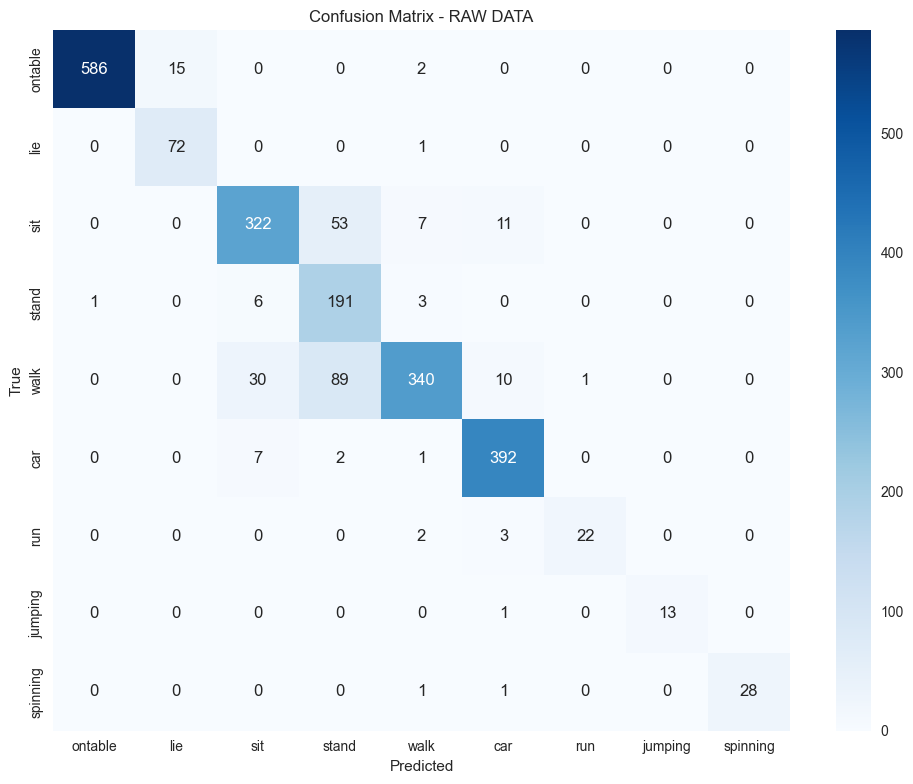

              precision    recall  f1-score   support

     ontable       1.00      0.97      0.98       603
         lie       0.83      0.99      0.90        73
         sit       0.88      0.82      0.85       393
       stand       0.57      0.95      0.71       201
        walk       0.95      0.72      0.82       470
         car       0.94      0.98      0.96       402
         run       0.96      0.81      0.88        27
     jumping       1.00      0.93      0.96        14
    spinning       1.00      0.93      0.97        30

    accuracy                           0.89      2213
   macro avg       0.90      0.90      0.89      2213
weighted avg       0.91      0.89      0.89      2213

Balanced accuracy: 0.9003271541273334


In [21]:
# Test RAW modelu

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

target_names = ['ontable', 'lie', 'sit', 'stand', 'walk', 'car', 'run', 'jumping', 'spinning']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RAW DATA')
plt.tight_layout()
plt.show()

print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, np.argmax(y_pred, axis=1))}')

In [29]:
def calculate_periodicity(signal):
    """Vypočíta periodicitu a dĺžku periódy pomocou FFT."""
    if len(signal) < 2:
        return 0 
    fft_values = np.fft.fft(signal)
    frekvencie = np.fft.fftfreq(len(signal))
    dominantna_frekvencia = frekvencie[np.argmax(np.abs(fft_values[1:])) + 1]  # Ignorujeme DC komponent
    dlzka_periody = 1 / dominantna_frekvencia if dominantna_frekvencia != 0 else 0
    return dlzka_periody

def calculate_autocorrelation(signal):
    """Vypočíta maximálnu autokoreláciu."""
    if len(signal) < 2:
        return 0 
    autokorelacia = correlate(signal, signal, mode='full')[len(signal)-1:]
    maximalna_autokorelacia = np.max(autokorelacia[1:])  # Ignorujeme nultý posun
    return maximalna_autokorelacia

def calculate_dct_coefficients(signal, num_coefficients=10):
    """Vypočíta prvých `num_coefficients` DCT koeficientov."""
    if len(signal) < 2:
        return [0] * num_coefficients  # Ak je signál príliš krátky, vráť NaN
    signal_values = signal.values  # Konvertuj Pandas Series na NumPy pole
    dct_coefficients = dct(signal_values, norm='ortho')
    if len(dct_coefficients) < num_coefficients:
        dct_coefficients = np.append(dct_coefficients, [np.nan] * (num_coefficients - len(dct_coefficients)))
    return dct_coefficients[:num_coefficients]

In [30]:
# V TOMTO BLOKU PREBIEHA VÝPOČET PRÍZNAKOV PRE PRÍNAKOVÉ MODELY

df_to_save = pd.DataFrame(columns=['index', '5s_index', 'x_acc_mean', 'y_acc_mean', 'z_acc_mean', 'x_gyro_mean', 'y_gyro_mean', 'z_gyro_mean', 'x_mag_mean', 'y_mag_mean', 'z_mag_mean', 'x_abs_mean', 'y_abs_mean', 'z_abs_mean', 'x_rel_mean', 'y_rel_mean', 'z_rel_mean', 'x_acc_std', 'y_acc_std', 'z_acc_std', 'x_gyro_std', 'y_gyro_std', 'z_gyro_std', 'x_mag_std', 'y_mag_std', 'z_mag_std', 'x_abs_std', 'y_abs_std', 'z_abs_std', 'x_rel_std', 'y_rel_std', 'z_rel_std', 'x_acc_max', 'y_acc_max', 'z_acc_max', 'x_gyro_max', 'y_gyro_max', 'z_gyro_max', 'x_mag_max', 'y_mag_max', 'z_mag_max', 'x_abs_max', 'y_abs_max', 'z_abs_max', 'x_rel_max', 'y_rel_max', 'z_rel_max', 'x_acc_min', 'y_acc_min', 'z_acc_min', 'x_gyro_min', 'y_gyro_min', 'z_gyro_min', 'x_mag_min', 'y_mag_min', 'z_mag_min', 'x_abs_min', 'y_abs_min', 'z_abs_min', 'x_rel_min', 'y_rel_min', 'z_rel_min', 'x_acc_sma', 'y_acc_sma', 'z_acc_sma', 'x_gyro_sma', 'y_gyro_sma', 'z_gyro_sma', 'x_mag_sma', 'y_mag_sma', 'z_mag_sma', 'x_abs_sma', 'y_abs_sma', 'z_abs_sma', 'x_rel_sma', 'y_rel_sma', 'z_rel_sma', 'x_acc_energy', 'y_acc_energy', 'z_acc_energy', 'x_gyro_energy', 'y_gyro_energy', 'z_gyro_energy', 'x_mag_energy', 'y_mag_energy', 'z_mag_energy', 'x_abs_energy', 'y_abs_energy', 'z_abs_energy', 'x_rel_energy', 'y_rel_energy', 'z_rel_energy', 'x_acc_iqr', 'y_acc_iqr', 'z_acc_iqr', 'x_gyro_iqr', 'y_gyro_iqr', 'z_gyro_iqr', 'x_mag_iqr', 'y_mag_iqr', 'z_mag_iqr', 'x_abs_iqr', 'y_abs_iqr', 'z_abs_iqr', 'x_rel_iqr', 'y_rel_iqr', 'z_rel_iqr', 'x_acc_skew', 'y_acc_skew', 'z_acc_skew', 'x_gyro_skew', 'y_gyro_skew', 'z_gyro_skew', 'x_mag_skew', 'y_mag_skew', 'z_mag_skew', 'x_abs_skew', 'y_abs_skew', 'z_abs_skew', 'x_rel_skew', 'y_rel_skew', 'z_rel_skew', 'x_acc_kurtosis', 'y_acc_kurtosis', 'z_acc_kurtosis', 'x_gyro_kurtosis', 'y_gyro_kurtosis', 'z_gyro_kurtosis', 'x_mag_kurtosis', 'y_mag_kurtosis', 'z_mag_kurtosis', 'x_abs_kurtosis', 'y_abs_kurtosis', 'z_abs_kurtosis', 'x_rel_kurtosis', 'y_rel_kurtosis', 
                                   'z_rel_kurtosis', 'x_acc_periodicity', 'y_acc_periodicity', 'z_acc_periodicity', 'x_gyro_periodicity', 'y_gyro_periodicity', 'z_gyro_periodicity', 'x_mag_periodicity', 'y_mag_periodicity', 'z_mag_periodicity', 'x_abs_periodicity', 'y_abs_periodicity', 'z_abs_periodicity', 'x_rel_periodicity', 'y_rel_periodicity', 'z_rel_periodicity', 'x_acc_autocorr', 'y_acc_autocorr', 'z_acc_autocorr', 'x_gyro_autocorr', 'y_gyro_autocorr', 'z_gyro_autocorr', 'x_mag_autocorr', 'y_mag_autocorr', 'z_mag_autocorr', 'x_abs_autocorr', 'y_abs_autocorr', 'z_abs_autocorr', 'x_rel_autocorr', 'y_rel_autocorr', 'z_rel_autocorr', 'x_acc_dct_0', 'x_acc_dct_1', 'x_acc_dct_2', 'x_acc_dct_3', 'x_acc_dct_4', 'y_acc_dct_0', 'y_acc_dct_1', 'y_acc_dct_2', 'y_acc_dct_3', 'y_acc_dct_4', 'z_acc_dct_0', 'z_acc_dct_1', 'z_acc_dct_2', 'z_acc_dct_3', 'z_acc_dct_4', 'x_gyro_dct_0', 'x_gyro_dct_1', 'x_gyro_dct_2', 'x_gyro_dct_3', 'x_gyro_dct_4', 'y_gyro_dct_0', 'y_gyro_dct_1', 'y_gyro_dct_2', 'y_gyro_dct_3', 'y_gyro_dct_4', 'z_gyro_dct_0', 'z_gyro_dct_1', 'z_gyro_dct_2', 'z_gyro_dct_3', 'z_gyro_dct_4', 'x_mag_dct_0', 'x_mag_dct_1', 'x_mag_dct_2', 'x_mag_dct_3', 'x_mag_dct_4', 'y_mag_dct_0', 'y_mag_dct_1', 'y_mag_dct_2', 'y_mag_dct_3', 'y_mag_dct_4', 'z_mag_dct_0', 'z_mag_dct_1', 'z_mag_dct_2', 'z_mag_dct_3', 'z_mag_dct_4', 'x_abs_dct_0', 'x_abs_dct_1', 'x_abs_dct_2', 'x_abs_dct_3', 'x_abs_dct_4', 'y_abs_dct_0', 'y_abs_dct_1', 'y_abs_dct_2', 'y_abs_dct_3', 'y_abs_dct_4', 'z_abs_dct_0', 'z_abs_dct_1', 'z_abs_dct_2', 'z_abs_dct_3', 'z_abs_dct_4', 'x_rel_dct_0', 'x_rel_dct_1', 'x_rel_dct_2', 'x_rel_dct_3', 'x_rel_dct_4', 'y_rel_dct_0', 'y_rel_dct_1', 'y_rel_dct_2', 'y_rel_dct_3', 'y_rel_dct_4', 'z_rel_dct_0', 'z_rel_dct_1', 'z_rel_dct_2', 'z_rel_dct_3', 'z_rel_dct_4', 'activity'])
bad_indexes = {291, 293, 303, 304, 319, 322, 325, 329, 342, 566, 598}  # Indexy v ktorých chyábjú hodnoty (preskočím ich čo už s nimi)

counter = 1 # counter pre db indexy

for index, df2 in enumerate(dfs):
    try:        
        if (index + 1 in bad_indexes):
            continue
        
        # Pre každý riadok, extrahujte surové dáta pre akcelerometer, gyroskop a magnetometer
        acce_flat_data = pd.json_normalize(df2.iloc[0]['AcceExtractedData'])
        gyro_flat_data = pd.json_normalize(df2.iloc[0]['GyroExtractedData'])
        magnet_flat_data = pd.json_normalize(df2.iloc[0]['MagnetExtractedData'])
        absorientation_flat_data = pd.json_normalize(df2.iloc[0]['AbsoluteOrientationExtractedData'])
        relorientation_flat_data = pd.json_normalize(df2.iloc[0]['RelativeOrientatioExtractedData'])

        if (acce_flat_data.empty or 
            gyro_flat_data.empty or 
            magnet_flat_data.empty or 
            absorientation_flat_data.empty or 
            relorientation_flat_data.empty):
            continue

        # Odstránenie nepotrebných stĺpcov
        acce_flat_data = acce_flat_data[['t', 'x', 'y', 'z']]
        gyro_flat_data = gyro_flat_data[['t', 'x', 'y', 'z']]
        magnet_flat_data = magnet_flat_data[['t', 'x', 'y', 'z']]
        absorientation_flat_data = absorientation_flat_data[['t', 'x', 'y', 'z']]
        relorientation_flat_data = relorientation_flat_data[['t', 'x', 'y', 'z']]
        
        # Nastavenie časového stĺpca ako index a rozdelenie na intervaly
        acce_flat_data['t'] = pd.to_datetime(acce_flat_data['t'], unit='ms')
        gyro_flat_data['t'] = pd.to_datetime(gyro_flat_data['t'], unit='ms')
        magnet_flat_data['t'] = pd.to_datetime(magnet_flat_data['t'], unit='ms')
        absorientation_flat_data['t'] = pd.to_datetime(absorientation_flat_data['t'], unit='ms')
        relorientation_flat_data['t'] = pd.to_datetime(relorientation_flat_data['t'], unit='ms')

        #Premenujem stĺpce
        acce_flat_data = acce_flat_data.rename(columns={'x': 'x_acc', 'y': 'y_acc', 'z': 'z_acc', 't': 't_acc'})
        gyro_flat_data = gyro_flat_data.rename(columns={'x': 'x_gyro', 'y': 'y_gyro', 'z': 'z_gyro', 't': 't_gyro'})
        magnet_flat_data = magnet_flat_data.rename(columns={'x': 'x_mag', 'y': 'y_mag', 'z': 'z_mag', 't': 't_mag'})
        absorientation_flat_data = absorientation_flat_data.rename(columns={'x': 'x_abs', 'y': 'y_abs', 'z': 'z_abs', 't': 't_abs'})
        relorientation_flat_data = relorientation_flat_data.rename(columns={'x': 'x_rel', 'y': 'y_rel', 'z': 'z_rel', 't': 't_rel'})
        
        acce_flat_data = acce_flat_data.set_index('t_acc')
        gyro_flat_data = gyro_flat_data.set_index('t_gyro')
        magnet_flat_data = magnet_flat_data.set_index('t_mag')
        absorientation_flat_data = absorientation_flat_data.set_index('t_abs')
        relorientation_flat_data = relorientation_flat_data.set_index('t_rel')
        
        # Resampling dát na 1-sekundové intervaly 
        interval_length = 1000  # 1 SEKUNDA
        # MEAN
        acce_resampled_mean = acce_flat_data.resample(f'{interval_length}ms').mean().interpolate().rename(columns={'x_acc': 'x_acc_mean','y_acc': 'y_acc_mean','z_acc': 'z_acc_mean'})
        gyro_resampled_mean = gyro_flat_data.resample(f'{interval_length}ms').mean().interpolate().rename(columns={'x_gyro': 'x_gyro_mean','y_gyro': 'y_gyro_mean','z_gyro': 'z_gyro_mean'})
        magnet_resampled_mean = magnet_flat_data.resample(f'{interval_length}ms').mean().interpolate().rename(columns={'x_mag': 'x_mag_mean','y_mag': 'y_mag_mean','z_mag': 'z_mag_mean'})
        absorientation_resampled_mean = absorientation_flat_data.resample(f'{interval_length}ms').mean().interpolate().rename(columns={'x_abs': 'x_abs_mean','y_abs': 'y_abs_mean','z_abs': 'z_abs_mean'})
        relorientation_resampled_mean = relorientation_flat_data.resample(f'{interval_length}ms').mean().interpolate().rename(columns={'x_rel': 'x_rel_mean','y_rel': 'y_rel_mean','z_rel': 'z_rel_mean'})
        
        # STD odchylka
        acce_resampled_std = acce_flat_data.resample(f'{interval_length}ms').std().interpolate().rename(columns={'x_acc': 'x_acc_std','y_acc': 'y_acc_std','z_acc': 'z_acc_std'})
        gyro_resampled_std = gyro_flat_data.resample(f'{interval_length}ms').std().interpolate().rename(columns={'x_gyro': 'x_gyro_std','y_gyro': 'y_gyro_std','z_gyro': 'z_gyro_std'})
        magnet_resampled_std = magnet_flat_data.resample(f'{interval_length}ms').std().interpolate().rename(columns={'x_mag': 'x_mag_std','y_mag': 'y_mag_std','z_mag': 'z_mag_std'})
        absorientation_resampled_std = absorientation_flat_data.resample(f'{interval_length}ms').std().interpolate().rename(columns={'x_abs': 'x_abs_std','y_abs': 'y_abs_std','z_abs': 'z_abs_std'})
        relorientation_resampled_std = relorientation_flat_data.resample(f'{interval_length}ms').std().interpolate().rename(columns={'x_rel': 'x_rel_std','y_rel': 'y_rel_std','z_rel': 'z_rel_std'})
        
        # MAX
        acce_resampled_max = acce_flat_data.resample(f'{interval_length}ms').max().interpolate().rename(columns={'x_acc': 'x_acc_max','y_acc': 'y_acc_max','z_acc': 'z_acc_max'})
        gyro_resampled_max = gyro_flat_data.resample(f'{interval_length}ms').max().interpolate().rename(columns={'x_gyro': 'x_gyro_max','y_gyro': 'y_gyro_max','z_gyro': 'z_gyro_max'})
        magnet_resampled_max = magnet_flat_data.resample(f'{interval_length}ms').max().interpolate().rename(columns={'x_mag': 'x_mag_max','y_mag': 'y_mag_max','z_mag': 'z_mag_max'})
        absorientation_resampled_max = absorientation_flat_data.resample(f'{interval_length}ms').max().interpolate().rename(columns={'x_abs': 'x_abs_max','y_abs': 'y_abs_max','z_abs': 'z_abs_max'})
        relorientation_resampled_max = relorientation_flat_data.resample(f'{interval_length}ms').max().interpolate().rename(columns={'x_rel': 'x_rel_max','y_rel': 'y_rel_max','z_rel': 'z_rel_max'})
        
        # MIN
        acce_resampled_min = acce_flat_data.resample(f'{interval_length}ms').min().interpolate().rename(columns={'x_acc': 'x_acc_min','y_acc': 'y_acc_min','z_acc': 'z_acc_min'})
        gyro_resampled_min = gyro_flat_data.resample(f'{interval_length}ms').min().interpolate().rename(columns={'x_gyro': 'x_gyro_min','y_gyro': 'y_gyro_min','z_gyro': 'z_gyro_min'})
        magnet_resampled_min = magnet_flat_data.resample(f'{interval_length}ms').min().interpolate().rename(columns={'x_mag': 'x_mag_min','y_mag': 'y_mag_min','z_mag': 'z_mag_min'})
        absorientation_resampled_min = absorientation_flat_data.resample(f'{interval_length}ms').min().interpolate().rename(columns={'x_abs': 'x_abs_min','y_abs': 'y_abs_min','z_abs': 'z_abs_min'})
        relorientation_resampled_min = relorientation_flat_data.resample(f'{interval_length}ms').min().interpolate().rename(columns={'x_rel': 'x_rel_min','y_rel': 'y_rel_min','z_rel': 'z_rel_min'})
        
        # Signal Magnitude Area
        acce_resampled_sma = acce_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.abs().sum()).interpolate().rename(columns={'x_acc': 'x_acc_sma','y_acc': 'y_acc_sma','z_acc': 'z_acc_sma'})
        gyro_resampled_sma = gyro_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.abs().sum()).interpolate().rename(columns={'x_gyro': 'x_gyro_sma','y_gyro': 'y_gyro_sma','z_gyro': 'z_gyro_sma'})
        magnet_resampled_sma = magnet_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.abs().sum()).interpolate().rename(columns={'x_mag': 'x_mag_sma','y_mag': 'y_mag_sma','z_mag': 'z_mag_sma'})
        absorientation_resampled_sma = absorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.abs().sum()).interpolate().rename(columns={'x_abs': 'x_abs_sma','y_abs': 'y_abs_sma','z_abs': 'z_abs_sma'})
        relorientation_resampled_sma = relorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.abs().sum()).interpolate().rename(columns={'x_rel': 'x_rel_sma','y_rel': 'y_rel_sma','z_rel': 'z_rel_sma'})
        
        # ENERGY (súčet štvorcov hodnôt)
        acce_resampled_energy = acce_flat_data.resample(f'{interval_length}ms').apply(lambda x: (x**2).mean()).interpolate().rename(columns={'x_acc': 'x_acc_energy','y_acc': 'y_acc_energy','z_acc': 'z_acc_energy'})
        gyro_resampled_energy = gyro_flat_data.resample(f'{interval_length}ms').apply(lambda x: (x**2).mean()).interpolate().rename(columns={'x_gyro': 'x_gyro_energy','y_gyro': 'y_gyro_energy','z_gyro': 'z_gyro_energy'})
        magnet_resampled_energy = magnet_flat_data.resample(f'{interval_length}ms').apply(lambda x: (x**2).mean()).interpolate().rename(columns={'x_mag': 'x_mag_energy','y_mag': 'y_mag_energy','z_mag': 'z_mag_energy'})
        absorientation_resampled_energy = absorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: (x**2).mean()).interpolate().rename(columns={'x_abs': 'x_abs_energy','y_abs': 'y_abs_energy','z_abs': 'z_abs_energy'})
        relorientation_resampled_energy = relorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: (x**2).mean()).interpolate().rename(columns={'x_rel': 'x_rel_energy','y_rel': 'y_rel_energy','z_rel': 'z_rel_energy'})
        
        # IQR (Interquartile Range)
        acce_resampled_iqr = acce_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).interpolate().rename(columns={'x_acc': 'x_acc_iqr','y_acc': 'y_acc_iqr','z_acc': 'z_acc_iqr'})
        gyro_resampled_iqr = gyro_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).interpolate().rename(columns={'x_gyro': 'x_gyro_iqr','y_gyro': 'y_gyro_iqr','z_gyro': 'z_gyro_iqr'})
        magnet_resampled_iqr = magnet_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).interpolate().rename(columns={'x_mag': 'x_mag_iqr','y_mag': 'y_mag_iqr','z_mag': 'z_mag_iqr'})
        absorientation_resampled_iqr = absorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).interpolate().rename(columns={'x_abs': 'x_abs_iqr','y_abs': 'y_abs_iqr','z_abs': 'z_abs_iqr'})
        relorientation_resampled_iqr = relorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).interpolate().rename(columns={'x_rel': 'x_rel_iqr','y_rel': 'y_rel_iqr','z_rel': 'z_rel_iqr'})
        
        # SKEWNESS
        acce_resampled_skewness = acce_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.skew()).interpolate().rename(columns={'x_acc': 'x_acc_skew','y_acc': 'y_acc_skew','z_acc': 'z_acc_skew'})
        gyro_resampled_skewness = gyro_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.skew()).interpolate().rename(columns={'x_gyro': 'x_gyro_skew','y_gyro': 'y_gyro_skew','z_gyro': 'z_gyro_skew'})
        magnet_resampled_skewness = magnet_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.skew()).interpolate().rename(columns={'x_mag': 'x_mag_skew','y_mag': 'y_mag_skew','z_mag': 'z_mag_skew'})
        absorientation_resampled_skewness = absorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.skew()).interpolate().rename(columns={'x_abs': 'x_abs_skew','y_abs': 'y_abs_skew','z_abs': 'z_abs_skew'})
        relorientation_resampled_skewness = relorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.skew()).interpolate().rename(columns={'x_rel': 'x_rel_skew','y_rel': 'y_rel_skew','z_rel': 'z_rel_skew'})
        
        # KURTOSIS
        acce_resampled_kurtosis = acce_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.kurtosis()).interpolate().rename(columns={'x_acc': 'x_acc_kurtosis','y_acc': 'y_acc_kurtosis','z_acc': 'z_acc_kurtosis'})
        gyro_resampled_kurtosis = gyro_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.kurtosis()).interpolate().rename(columns={'x_gyro': 'x_gyro_kurtosis','y_gyro': 'y_gyro_kurtosis','z_gyro': 'z_gyro_kurtosis'})
        magnet_resampled_kurtosis = magnet_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.kurtosis()).interpolate().rename(columns={'x_mag': 'x_mag_kurtosis','y_mag': 'y_mag_kurtosis','z_mag': 'z_mag_kurtosis'})
        absorientation_resampled_kurtosis = absorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.kurtosis()).interpolate().rename(columns={'x_abs': 'x_abs_kurtosis','y_abs': 'y_abs_kurtosis','z_abs': 'z_abs_kurtosis'})
        relorientation_resampled_kurtosis = relorientation_flat_data.resample(f'{interval_length}ms').apply(lambda x: x.kurtosis()).interpolate().rename(columns={'x_rel': 'x_rel_kurtosis','y_rel': 'y_rel_kurtosis','z_rel': 'z_rel_kurtosis'})

        # PERIODICIA SIGNÁLU
        acce_resampled_periodicity = acce_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_acc_periodicity': calculate_periodicity(x['x_acc'].dropna()),
                'y_acc_periodicity': calculate_periodicity(x['y_acc'].dropna()),
                'z_acc_periodicity': calculate_periodicity(x['z_acc'].dropna())
            })
        ).interpolate()

        gyro_resampled_periodicity = gyro_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_gyro_periodicity': calculate_periodicity(x['x_gyro'].dropna()),
                'y_gyro_periodicity': calculate_periodicity(x['y_gyro'].dropna()),
                'z_gyro_periodicity': calculate_periodicity(x['z_gyro'].dropna())
            })
        ).interpolate()

        magnet_resampled_periodicity = magnet_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_mag_periodicity': calculate_periodicity(x['x_mag'].dropna()),
                'y_mag_periodicity': calculate_periodicity(x['y_mag'].dropna()),
                'z_mag_periodicity': calculate_periodicity(x['z_mag'].dropna())
            })
        ).interpolate()

        absorientation_resampled_periodicity = absorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_abs_periodicity': calculate_periodicity(x['x_abs'].dropna()),
                'y_abs_periodicity': calculate_periodicity(x['y_abs'].dropna()),
                'z_abs_periodicity': calculate_periodicity(x['z_abs'].dropna())
            })
        ).interpolate()

        relorientation_resampled_periodicity = relorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_rel_periodicity': calculate_periodicity(x['x_rel'].dropna()),
                'y_rel_periodicity': calculate_periodicity(x['y_rel'].dropna()),
                'z_rel_periodicity': calculate_periodicity(x['z_rel'].dropna())
            })
        ).interpolate()

        #AUTOKORELÁCIA
        acce_resampled_autocorr = acce_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_acc_autocorr': calculate_autocorrelation(x['x_acc'].dropna()),
                'y_acc_autocorr': calculate_autocorrelation(x['y_acc'].dropna()),
                'z_acc_autocorr': calculate_autocorrelation(x['z_acc'].dropna())
            })
        ).interpolate()

        gyro_resampled_autocorr = gyro_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_gyro_autocorr': calculate_autocorrelation(x['x_gyro'].dropna()),
                'y_gyro_autocorr': calculate_autocorrelation(x['y_gyro'].dropna()),
                'z_gyro_autocorr': calculate_autocorrelation(x['z_gyro'].dropna())
            })
        ).interpolate()

        magnet_resampled_autocorr = magnet_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_mag_autocorr': calculate_autocorrelation(x['x_mag'].dropna()),
                'y_mag_autocorr': calculate_autocorrelation(x['y_mag'].dropna()),
                'z_mag_autocorr': calculate_autocorrelation(x['z_mag'].dropna())
            })
        ).interpolate()

        absorientation_resampled_autocorr = absorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_abs_autocorr': calculate_autocorrelation(x['x_abs'].dropna()),
                'y_abs_autocorr': calculate_autocorrelation(x['y_abs'].dropna()),
                'z_abs_autocorr': calculate_autocorrelation(x['z_abs'].dropna())
            })
        ).interpolate()

        relorientation_resampled_autocorr = relorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                'x_rel_autocorr': calculate_autocorrelation(x['x_rel'].dropna()),
                'y_rel_autocorr': calculate_autocorrelation(x['y_rel'].dropna()),
                'z_rel_autocorr': calculate_autocorrelation(x['z_rel'].dropna())
            })
        ).interpolate()
        
        # DCT KOEFICIENTY
        num_coefficients = 5 # počet koeficientov volim 5, hadam to bude dosť
        
        acce_resampled_dct = acce_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                **{f'x_acc_dct_{i}': calculate_dct_coefficients(x['x_acc'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'y_acc_dct_{i}': calculate_dct_coefficients(x['y_acc'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'z_acc_dct_{i}': calculate_dct_coefficients(x['z_acc'].dropna(), 5)[i] for i in range(num_coefficients)}
            })
        ).interpolate()

        gyro_resampled_dct = gyro_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                **{f'x_gyro_dct_{i}': calculate_dct_coefficients(x['x_gyro'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'y_gyro_dct_{i}': calculate_dct_coefficients(x['y_gyro'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'z_gyro_dct_{i}': calculate_dct_coefficients(x['z_gyro'].dropna(), 5)[i] for i in range(num_coefficients)}
            })
        ).interpolate()

        magnet_resampled_dct = magnet_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                **{f'x_mag_dct_{i}': calculate_dct_coefficients(x['x_mag'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'y_mag_dct_{i}': calculate_dct_coefficients(x['y_mag'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'z_mag_dct_{i}': calculate_dct_coefficients(x['z_mag'].dropna(), 5)[i] for i in range(num_coefficients)}
            })
        ).interpolate()

        absorientation_resampled_dct = absorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                **{f'x_abs_dct_{i}': calculate_dct_coefficients(x['x_abs'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'y_abs_dct_{i}': calculate_dct_coefficients(x['y_abs'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'z_abs_dct_{i}': calculate_dct_coefficients(x['z_abs'].dropna(), 5)[i] for i in range(num_coefficients)}
            })
        ).interpolate()

        relorientation_resampled_dct = relorientation_flat_data.resample(f'{interval_length}ms').apply(
            lambda x: pd.Series({
                **{f'x_rel_dct_{i}': calculate_dct_coefficients(x['x_rel'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'y_rel_dct_{i}': calculate_dct_coefficients(x['y_rel'].dropna(), 5)[i] for i in range(num_coefficients)},
                **{f'z_rel_dct_{i}': calculate_dct_coefficients(x['z_rel'].dropna(), 5)[i] for i in range(num_coefficients)}
            })
        ).interpolate()

        
        # Spojenie dát z troch senzorov do jedného DataFrame na základe časových pečiatok
        merged_data = pd.concat([
            acce_resampled_mean, gyro_resampled_mean, magnet_resampled_mean, absorientation_resampled_mean, relorientation_resampled_mean,
            acce_resampled_std, gyro_resampled_std, magnet_resampled_std, absorientation_resampled_std, relorientation_resampled_std,
            acce_resampled_max, gyro_resampled_max, magnet_resampled_max, absorientation_resampled_max, relorientation_resampled_max,
            acce_resampled_min, gyro_resampled_min, magnet_resampled_min, absorientation_resampled_min, relorientation_resampled_min,
            acce_resampled_sma, gyro_resampled_sma, magnet_resampled_sma, absorientation_resampled_sma, relorientation_resampled_sma,
            acce_resampled_energy, gyro_resampled_energy, magnet_resampled_energy, absorientation_resampled_energy, relorientation_resampled_energy,
            acce_resampled_iqr, gyro_resampled_iqr, magnet_resampled_iqr, absorientation_resampled_iqr, relorientation_resampled_iqr,
            acce_resampled_skewness, gyro_resampled_skewness, magnet_resampled_skewness, absorientation_resampled_skewness, relorientation_resampled_skewness,
            acce_resampled_kurtosis, gyro_resampled_kurtosis, magnet_resampled_kurtosis, absorientation_resampled_kurtosis, relorientation_resampled_kurtosis,
            acce_resampled_periodicity, gyro_resampled_periodicity, magnet_resampled_periodicity, absorientation_resampled_periodicity, relorientation_resampled_periodicity,
            acce_resampled_autocorr, gyro_resampled_autocorr, magnet_resampled_autocorr, absorientation_resampled_autocorr, relorientation_resampled_autocorr,
            acce_resampled_dct, gyro_resampled_dct, magnet_resampled_dct, absorientation_resampled_dct, relorientation_resampled_dct
        ], axis=1)
        
        # Resetovanie indexu a znovu nastavenie časového indexu na milisekundy
        merged_data.reset_index(inplace=True)
        merged_data['index'] = merged_data['index'].astype('int64') // 1_000_000  # Nastavenie t späť do milisekúnd .view
        merged_data = merged_data.rename(columns={'index': '5s_index'})
        
        # Ak posledný záznam obsahuje NULL hodnotu
        while merged_data.iloc[-1].isnull().any():
            merged_data = merged_data.drop(merged_data.index[-1])  # odstrán a nič iné
        
        # Ak prvý  záznam aktivity obsahuje NULL hodnotu
        if merged_data.iloc[0].isnull().any():  # Ak prvý záznam obsahuje NULL
            merged_data = merged_data.drop(merged_data.index[0])
            merged_data['5s_index'] = merged_data['5s_index'] - interval_length
        
        # Dopĺňame názov aktivity
        merged_data['activity'] = df2.iloc[0]['Activity']
        
        # Vkladáme index do dát
        merged_data.insert(0, 'index', counter)
        counter += 1

        if (merged_data['5s_index'].diff().drop(0) != interval_length).any():
            print("INDEX: ", index)
            print("COUNTER: ", index)
        
        # Pridanie do finálneho DataFrame
        df_to_save = pd.concat([df_to_save, merged_data], ignore_index=True)

        print("END INDEX " + str(index))

    except KeyError:
        print("KeyError")
        continue
    except TypeError:
        print("TypeError")
        continue


# Spojenie dát z troch senzorov do jedného DataFrame na základe časových pečiatok
# merged_data = pd.merge_asof(acce_flat_data, gyro_flat_data, on='t', direction='nearest')
# merged_data = pd.merge_asof(merged_data, magnet_flat_data, on='t', direction='nearest')


END INDEX 0
END INDEX 1
END INDEX 2
END INDEX 3
END INDEX 4
END INDEX 5
END INDEX 6
END INDEX 7
END INDEX 8
END INDEX 9
END INDEX 10
END INDEX 11
END INDEX 12
END INDEX 13
END INDEX 14
END INDEX 15
END INDEX 16
END INDEX 17
END INDEX 18
END INDEX 19
END INDEX 20
END INDEX 21
END INDEX 22
END INDEX 23
END INDEX 24
END INDEX 25
END INDEX 26
END INDEX 27
END INDEX 28
END INDEX 29
END INDEX 30
END INDEX 31
END INDEX 32
END INDEX 33
END INDEX 34
END INDEX 35
END INDEX 36
END INDEX 37
END INDEX 38
END INDEX 39
END INDEX 40
END INDEX 41
END INDEX 42
END INDEX 43
END INDEX 44
END INDEX 45
END INDEX 46
END INDEX 47
END INDEX 48
END INDEX 49
END INDEX 50
END INDEX 51
END INDEX 52
END INDEX 53
END INDEX 54
END INDEX 55
END INDEX 56
END INDEX 57
END INDEX 58
END INDEX 59
END INDEX 60
END INDEX 61
END INDEX 62
END INDEX 63
END INDEX 64
END INDEX 65
END INDEX 66
END INDEX 67
END INDEX 68
END INDEX 69
END INDEX 70
END INDEX 71
END INDEX 72
END INDEX 73
END INDEX 74
END INDEX 75
END INDEX 76
END INDEX

In [31]:
print(df_to_save.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59743 entries, 0 to 59742
Columns: 243 entries, index to activity
dtypes: float64(240), object(3)
memory usage: 110.8+ MB
None


In [32]:
try:
    # Vytvorenie pripojenia
    connection = mysql.connector.connect(
        host='127.0.0.1',
        user='root',
        password='',
        database='gapi_dataset'
    )

    cursor = connection.cursor()

    # Vytvorenie tabuľky, ak ešte neexistuje
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS sensor_data (
        `index` BIGINT(20),
        `ms_index` BIGINT(20),
        `x_acc_mean` DOUBLE,
        `y_acc_mean` DOUBLE,
        `z_acc_mean` DOUBLE,
        `x_gyro_mean` DOUBLE,
        `y_gyro_mean` DOUBLE,
        `z_gyro_mean` DOUBLE,
        `x_mag_mean` DOUBLE,
        `y_mag_mean` DOUBLE,
        `z_mag_mean` DOUBLE,
        `x_abs_mean` DOUBLE,
        `y_abs_mean` DOUBLE,
        `z_abs_mean` DOUBLE,
        `x_rel_mean` DOUBLE,
        `y_rel_mean` DOUBLE,
        `z_rel_mean` DOUBLE,
        `x_acc_std` DOUBLE,
        `y_acc_std` DOUBLE,
        `z_acc_std` DOUBLE,
        `x_gyro_std` DOUBLE,
        `y_gyro_std` DOUBLE,
        `z_gyro_std` DOUBLE,
        `x_mag_std` DOUBLE,
        `y_mag_std` DOUBLE,
        `z_mag_std` DOUBLE,
        `x_abs_std` DOUBLE,
        `y_abs_std` DOUBLE,
        `z_abs_std` DOUBLE,
        `x_rel_std` DOUBLE,
        `y_rel_std` DOUBLE,
        `z_rel_std` DOUBLE,
        `x_acc_max` DOUBLE,
        `y_acc_max` DOUBLE,
        `z_acc_max` DOUBLE,
        `x_gyro_max` DOUBLE,
        `y_gyro_max` DOUBLE,
        `z_gyro_max` DOUBLE,
        `x_mag_max` DOUBLE,
        `y_mag_max` DOUBLE,
        `z_mag_max` DOUBLE,
        `x_abs_max` DOUBLE,
        `y_abs_max` DOUBLE,
        `z_abs_max` DOUBLE,
        `x_rel_max` DOUBLE,
        `y_rel_max` DOUBLE,
        `z_rel_max` DOUBLE,
        `x_acc_min` DOUBLE,
        `y_acc_min` DOUBLE,
        `z_acc_min` DOUBLE,
        `x_gyro_min` DOUBLE,
        `y_gyro_min` DOUBLE,
        `z_gyro_min` DOUBLE,
        `x_mag_min` DOUBLE,
        `y_mag_min` DOUBLE,
        `z_mag_min` DOUBLE,
        `x_abs_min` DOUBLE,
        `y_abs_min` DOUBLE,
        `z_abs_min` DOUBLE,
        `x_rel_min` DOUBLE,
        `y_rel_min` DOUBLE,
        `z_rel_min` DOUBLE,
        `x_acc_sma` DOUBLE,
        `y_acc_sma` DOUBLE,
        `z_acc_sma` DOUBLE,
        `x_gyro_sma` DOUBLE,
        `y_gyro_sma` DOUBLE,
        `z_gyro_sma` DOUBLE,
        `x_mag_sma` DOUBLE,
        `y_mag_sma` DOUBLE,
        `z_mag_sma` DOUBLE,
        `x_abs_sma` DOUBLE,
        `y_abs_sma` DOUBLE,
        `z_abs_sma` DOUBLE,
        `x_rel_sma` DOUBLE,
        `y_rel_sma` DOUBLE,
        `z_rel_sma` DOUBLE,
        `x_acc_energy` DOUBLE,
        `y_acc_energy` DOUBLE,
        `z_acc_energy` DOUBLE,
        `x_gyro_energy` DOUBLE,
        `y_gyro_energy` DOUBLE,
        `z_gyro_energy` DOUBLE,
        `x_mag_energy` DOUBLE,
        `y_mag_energy` DOUBLE,
        `z_mag_energy` DOUBLE,
        `x_abs_energy` DOUBLE,
        `y_abs_energy` DOUBLE,
        `z_abs_energy` DOUBLE,
        `x_rel_energy` DOUBLE,
        `y_rel_energy` DOUBLE,
        `z_rel_energy` DOUBLE,
        `x_acc_iqr` DOUBLE,
        `y_acc_iqr` DOUBLE,
        `z_acc_iqr` DOUBLE,
        `x_gyro_iqr` DOUBLE,
        `y_gyro_iqr` DOUBLE,
        `z_gyro_iqr` DOUBLE,
        `x_mag_iqr` DOUBLE,
        `y_mag_iqr` DOUBLE,
        `z_mag_iqr` DOUBLE,
        `x_abs_iqr` DOUBLE,
        `y_abs_iqr` DOUBLE,
        `z_abs_iqr` DOUBLE,
        `x_rel_iqr` DOUBLE,
        `y_rel_iqr` DOUBLE,
        `z_rel_iqr` DOUBLE,
        `x_acc_skew` DOUBLE,
        `y_acc_skew` DOUBLE,
        `z_acc_skew` DOUBLE,
        `x_gyro_skew` DOUBLE,
        `y_gyro_skew` DOUBLE,
        `z_gyro_skew` DOUBLE,
        `x_mag_skew` DOUBLE,
        `y_mag_skew` DOUBLE,
        `z_mag_skew` DOUBLE,
        `x_abs_skew` DOUBLE,
        `y_abs_skew` DOUBLE,
        `z_abs_skew` DOUBLE,
        `x_rel_skew` DOUBLE,
        `y_rel_skew` DOUBLE,
        `z_rel_skew` DOUBLE,
        `x_acc_kurtosis` DOUBLE,
        `y_acc_kurtosis` DOUBLE,
        `z_acc_kurtosis` DOUBLE,
        `x_gyro_kurtosis` DOUBLE,
        `y_gyro_kurtosis` DOUBLE,
        `z_gyro_kurtosis` DOUBLE,
        `x_mag_kurtosis` DOUBLE,
        `y_mag_kurtosis` DOUBLE,
        `z_mag_kurtosis` DOUBLE,
        `x_abs_kurtosis` DOUBLE,
        `y_abs_kurtosis` DOUBLE,
        `z_abs_kurtosis` DOUBLE,
        `x_rel_kurtosis` DOUBLE,
        `y_rel_kurtosis` DOUBLE,
        `z_rel_kurtosis` DOUBLE,
        `x_acc_periodicity` DOUBLE,
        `y_acc_periodicity` DOUBLE,
        `z_acc_periodicity` DOUBLE,
        `x_gyro_periodicity` DOUBLE,
        `y_gyro_periodicity` DOUBLE,
        `z_gyro_periodicity` DOUBLE,
        `x_mag_periodicity` DOUBLE,
        `y_mag_periodicity` DOUBLE,
        `z_mag_periodicity` DOUBLE,
        `x_abs_periodicity` DOUBLE,
        `y_abs_periodicity` DOUBLE,
        `z_abs_periodicity` DOUBLE,
        `x_rel_periodicity` DOUBLE,
        `y_rel_periodicity` DOUBLE,
        `z_rel_periodicity` DOUBLE,
        `x_acc_autocorr` DOUBLE,
        `y_acc_autocorr` DOUBLE,
        `z_acc_autocorr` DOUBLE,
        `x_gyro_autocorr` DOUBLE,
        `y_gyro_autocorr` DOUBLE,
        `z_gyro_autocorr` DOUBLE,
        `x_mag_autocorr` DOUBLE,
        `y_mag_autocorr` DOUBLE,
        `z_mag_autocorr` DOUBLE,
        `x_abs_autocorr` DOUBLE,
        `y_abs_autocorr` DOUBLE,
        `z_abs_autocorr` DOUBLE,
        `x_rel_autocorr` DOUBLE,
        `y_rel_autocorr` DOUBLE,
        `z_rel_autocorr` DOUBLE,
        `x_acc_dct_0` DOUBLE,
        `x_acc_dct_1` DOUBLE,
        `x_acc_dct_2` DOUBLE,
        `x_acc_dct_3` DOUBLE,
        `x_acc_dct_4` DOUBLE,
        `y_acc_dct_0` DOUBLE,
        `y_acc_dct_1` DOUBLE,
        `y_acc_dct_2` DOUBLE,
        `y_acc_dct_3` DOUBLE,
        `y_acc_dct_4` DOUBLE,
        `z_acc_dct_0` DOUBLE,
        `z_acc_dct_1` DOUBLE,
        `z_acc_dct_2` DOUBLE,
        `z_acc_dct_3` DOUBLE,
        `z_acc_dct_4` DOUBLE,
        `x_gyro_dct_0` DOUBLE,
        `x_gyro_dct_1` DOUBLE,
        `x_gyro_dct_2` DOUBLE,
        `x_gyro_dct_3` DOUBLE,
        `x_gyro_dct_4` DOUBLE,
        `y_gyro_dct_0` DOUBLE,
        `y_gyro_dct_1` DOUBLE,
        `y_gyro_dct_2` DOUBLE,
        `y_gyro_dct_3` DOUBLE,
        `y_gyro_dct_4` DOUBLE,
        `z_gyro_dct_0` DOUBLE,
        `z_gyro_dct_1` DOUBLE,
        `z_gyro_dct_2` DOUBLE,
        `z_gyro_dct_3` DOUBLE,
        `z_gyro_dct_4` DOUBLE,
        `x_mag_dct_0` DOUBLE,
        `x_mag_dct_1` DOUBLE,
        `x_mag_dct_2` DOUBLE,
        `x_mag_dct_3` DOUBLE,
        `x_mag_dct_4` DOUBLE,
        `y_mag_dct_0` DOUBLE,
        `y_mag_dct_1` DOUBLE,
        `y_mag_dct_2` DOUBLE,
        `y_mag_dct_3` DOUBLE,
        `y_mag_dct_4` DOUBLE,
        `z_mag_dct_0` DOUBLE,
        `z_mag_dct_1` DOUBLE,
        `z_mag_dct_2` DOUBLE,
        `z_mag_dct_3` DOUBLE,
        `z_mag_dct_4` DOUBLE,
        `x_abs_dct_0` DOUBLE,
        `x_abs_dct_1` DOUBLE,
        `x_abs_dct_2` DOUBLE,
        `x_abs_dct_3` DOUBLE,
        `x_abs_dct_4` DOUBLE,
        `y_abs_dct_0` DOUBLE,
        `y_abs_dct_1` DOUBLE,
        `y_abs_dct_2` DOUBLE,
        `y_abs_dct_3` DOUBLE,
        `y_abs_dct_4` DOUBLE,
        `z_abs_dct_0` DOUBLE,
        `z_abs_dct_1` DOUBLE,
        `z_abs_dct_2` DOUBLE,
        `z_abs_dct_3` DOUBLE,
        `z_abs_dct_4` DOUBLE,
        `x_rel_dct_0` DOUBLE,
        `x_rel_dct_1` DOUBLE,
        `x_rel_dct_2` DOUBLE,
        `x_rel_dct_3` DOUBLE,
        `x_rel_dct_4` DOUBLE,
        `y_rel_dct_0` DOUBLE,
        `y_rel_dct_1` DOUBLE,
        `y_rel_dct_2` DOUBLE,
        `y_rel_dct_3` DOUBLE,
        `y_rel_dct_4` DOUBLE,
        `z_rel_dct_0` DOUBLE,
        `z_rel_dct_1` DOUBLE,
        `z_rel_dct_2` DOUBLE,
        `z_rel_dct_3` DOUBLE,
        `z_rel_dct_4` DOUBLE,
        `activity` TEXT
    );
    """)

    cursor.execute("DELETE FROM sensor_data")
    connection.commit()

    for index, row in df_to_save.iterrows():
        cursor.execute("""
        INSERT INTO sensor_data (
            `index`, `ms_index`, `x_acc_mean`, `y_acc_mean`, `z_acc_mean`, `x_gyro_mean`, `y_gyro_mean`, `z_gyro_mean`, 
            `x_mag_mean`, `y_mag_mean`, `z_mag_mean`, `x_abs_mean`, `y_abs_mean`, `z_abs_mean`, `x_rel_mean`, `y_rel_mean`, `z_rel_mean`, 
            `x_acc_std`, `y_acc_std`, `z_acc_std`, `x_gyro_std`, `y_gyro_std`, `z_gyro_std`, `x_mag_std`, `y_mag_std`, `z_mag_std`, 
            `x_abs_std`, `y_abs_std`, `z_abs_std`, `x_rel_std`, `y_rel_std`, `z_rel_std`, `x_acc_max`, `y_acc_max`, `z_acc_max`, 
            `x_gyro_max`, `y_gyro_max`, `z_gyro_max`, `x_mag_max`, `y_mag_max`, `z_mag_max`, `x_abs_max`, `y_abs_max`, `z_abs_max`, 
            `x_rel_max`, `y_rel_max`, `z_rel_max`, `x_acc_min`, `y_acc_min`, `z_acc_min`, `x_gyro_min`, `y_gyro_min`, `z_gyro_min`, 
            `x_mag_min`, `y_mag_min`, `z_mag_min`, `x_abs_min`, `y_abs_min`, `z_abs_min`, `x_rel_min`, `y_rel_min`, `z_rel_min`, 
            `x_acc_sma`, `y_acc_sma`, `z_acc_sma`, `x_gyro_sma`, `y_gyro_sma`, `z_gyro_sma`, `x_mag_sma`, `y_mag_sma`, `z_mag_sma`, 
            `x_abs_sma`, `y_abs_sma`, `z_abs_sma`, `x_rel_sma`, `y_rel_sma`, `z_rel_sma`, `x_acc_energy`, `y_acc_energy`, `z_acc_energy`, 
            `x_gyro_energy`, `y_gyro_energy`, `z_gyro_energy`, `x_mag_energy`, `y_mag_energy`, `z_mag_energy`, `x_abs_energy`, `y_abs_energy`, 
            `z_abs_energy`, `x_rel_energy`, `y_rel_energy`, `z_rel_energy`, `x_acc_iqr`, `y_acc_iqr`, `z_acc_iqr`, `x_gyro_iqr`, `y_gyro_iqr`, 
            `z_gyro_iqr`, `x_mag_iqr`, `y_mag_iqr`, `z_mag_iqr`, `x_abs_iqr`, `y_abs_iqr`, `z_abs_iqr`, `x_rel_iqr`, `y_rel_iqr`, `z_rel_iqr`, 
            `x_acc_skew`, `y_acc_skew`, `z_acc_skew`, `x_gyro_skew`, `y_gyro_skew`, `z_gyro_skew`, `x_mag_skew`, `y_mag_skew`, `z_mag_skew`, 
            `x_abs_skew`, `y_abs_skew`, `z_abs_skew`, `x_rel_skew`, `y_rel_skew`, `z_rel_skew`, `x_acc_kurtosis`, `y_acc_kurtosis`, 
            `z_acc_kurtosis`, `x_gyro_kurtosis`, `y_gyro_kurtosis`, `z_gyro_kurtosis`, `x_mag_kurtosis`, `y_mag_kurtosis`, `z_mag_kurtosis`, 
            `x_abs_kurtosis`, `y_abs_kurtosis`, `z_abs_kurtosis`, `x_rel_kurtosis`, `y_rel_kurtosis`, `z_rel_kurtosis`, `x_acc_periodicity`,
            `y_acc_periodicity`, `z_acc_periodicity`, `x_gyro_periodicity`, `y_gyro_periodicity`, `z_gyro_periodicity`, `x_mag_periodicity`,
            `y_mag_periodicity`, `z_mag_periodicity`, `x_abs_periodicity`, `y_abs_periodicity`, `z_abs_periodicity`, `x_rel_periodicity`, 
            `y_rel_periodicity`, `z_rel_periodicity`, `x_acc_autocorr`, `y_acc_autocorr`, `z_acc_autocorr`, `x_gyro_autocorr`, `y_gyro_autocorr`,
            `z_gyro_autocorr`, `x_mag_autocorr`, `y_mag_autocorr`, `z_mag_autocorr`, `x_abs_autocorr`, `y_abs_autocorr`, `z_abs_autocorr`,
            `x_rel_autocorr`, `y_rel_autocorr`, `z_rel_autocorr`, `x_acc_dct_0`, `x_acc_dct_1`, `x_acc_dct_2`, `x_acc_dct_3`, `x_acc_dct_4`, 
            `y_acc_dct_0`, `y_acc_dct_1`, `y_acc_dct_2`, `y_acc_dct_3`, `y_acc_dct_4`, `z_acc_dct_0`, `z_acc_dct_1`, `z_acc_dct_2`, `z_acc_dct_3`, 
            `z_acc_dct_4`, `x_gyro_dct_0`, `x_gyro_dct_1`, `x_gyro_dct_2`, `x_gyro_dct_3`, `x_gyro_dct_4`, `y_gyro_dct_0`, `y_gyro_dct_1`, 
            `y_gyro_dct_2`, `y_gyro_dct_3`, `y_gyro_dct_4`, `z_gyro_dct_0`, `z_gyro_dct_1`, `z_gyro_dct_2`, `z_gyro_dct_3`, `z_gyro_dct_4`, 
            `x_mag_dct_0`, `x_mag_dct_1`, `x_mag_dct_2`, `x_mag_dct_3`, `x_mag_dct_4`, `y_mag_dct_0`, `y_mag_dct_1`, 
            `y_mag_dct_2`, `y_mag_dct_3`, `y_mag_dct_4`, `z_mag_dct_0`, `z_mag_dct_1`, `z_mag_dct_2`, `z_mag_dct_3`, 
            `z_mag_dct_4`, `x_abs_dct_0`, `x_abs_dct_1`, `x_abs_dct_2`, `x_abs_dct_3`, `x_abs_dct_4`, `y_abs_dct_0`, `y_abs_dct_1`, 
            `y_abs_dct_2`, `y_abs_dct_3`, `y_abs_dct_4`, `z_abs_dct_0`, `z_abs_dct_1`, `z_abs_dct_2`, `z_abs_dct_3`, `z_abs_dct_4`, `x_rel_dct_0`,
            `x_rel_dct_1`, `x_rel_dct_2`, `x_rel_dct_3`, `x_rel_dct_4`, `y_rel_dct_0`, `y_rel_dct_1`, `y_rel_dct_2`, `y_rel_dct_3`, `y_rel_dct_4`, 
            `z_rel_dct_0`, `z_rel_dct_1`, `z_rel_dct_2`, `z_rel_dct_3`, `z_rel_dct_4`, `activity`
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, 
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, 
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, 
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, tuple(row))

    connection.commit()

    print("Dáta boli úspešne uložené do MySQL databázy.")
except mysql.connector.Error as err:
    print(f"Chyba pri pripojení alebo ukladaní: {err}")
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

Dáta boli úspešne uložené do MySQL databázy.


In [33]:
# DATA PRE LSTM A GRU
# všetky aktivity
class_map = {'ontable': 0, 'lie': 1, 'sit': 2, 'stand': 3, 'walk': 4, 'car': 5, 'bus': 6, 'tram': 7, 'train': 8, 'metro':9, 'other':10, 'stairsUp':11, 'stairsDown':12, 'run':13, 'jumping': 14, 'spinning': 15}

try:    
    connection = mysql.connector.connect(
        host='127.0.0.1',
        user='root',
        password='',
        database='gapi_dataset'
    )

    cursor = connection.cursor()

    query = "SELECT * FROM sensor_data"
    db_data_nn = pd.read_sql(query, connection)

    db_data_nn['activity'] = db_data_nn['activity'].str.strip('"')
    db_data_nn['activity'] = db_data_nn['activity'].apply(lambda x: class_map[x])
except mysql.connector.Error as err:
    print(f"Chyba pri pripojení alebo ukladaní: {err}")
finally:
    # Zatvorenie pripojenia
    if connection.is_connected():
        cursor.close()
        connection.close()

In [34]:
# Vymazem niektore aktivity KTORÉ NEPOUžÍVAM

to_remove = [6, 7, 8, 9, 10, 11, 12]
db_data_nn = db_data_nn[~db_data_nn['activity'].isin(to_remove)]

# Získame unikátne hodnoty v stĺpci activity a zoradíme ich
unique_vals = sorted(db_data_nn['activity'].unique())

# Vytvoríme mapovanie, ktoré premapuje pôvodné hodnoty na sekvenčné čísla od 0 do n-1
mapping = {old: new for new, old in enumerate(unique_vals)}

# Aplikujeme mapovanie na stĺpec activity
db_data_nn['activity'] = db_data_nn['activity'].map(mapping)

In [35]:
def split_measurements(df, max_duration=5, offset=2):
    """
    Rozdelí merania v DataFrame na prekrývajúce sa segmenty podľa stanoveného offsetu.
    Slúži na obohatenie dát pre lepšiu generalizáciu siete
    
    - max_duration: maximálna dĺžka segmentu (napr. 5 sekúnd)
    - offset: posun medzi začiatkami segmentov (napr. 2 sekundy)
    """
    new_records = []  # Zoznam pre nové segmenty
    new_index_counter = 1  # Počítadlo pre nový index meraní

    for orig_index, group in df.groupby('index'):
        group = group.sort_values('ms_index')  # Usporiadanie podľa času
        n = len(group)
        start = 0  # Začiatočný index pre slicing

        while start + max_duration <= n:  # Pokračujeme, kým vieme vytvoriť celý segment
            chunk = group.iloc[start:start + max_duration].copy()
            chunk['index'] = new_index_counter
            chunk = chunk.reset_index(drop=True)
            chunk['ms_index'] = (chunk.index + 1) * 1000  # Resetovanie 'ms_index'
            new_records.append(chunk)
            new_index_counter += 1
            start += offset  # Posun začiatku segmentu o offset
    
    return pd.concat(new_records, ignore_index=True) if new_records else pd.DataFrame()


db_data_nn = split_measurements(db_data_nn, max_duration=5, offset=2)

db_data_nn.head(50)


,index,ms_index,x_acc_mean,y_acc_mean,z_acc_mean,x_gyro_mean,y_gyro_mean,z_gyro_mean,x_mag_mean,y_mag_mean,...,y_rel_dct_1,y_rel_dct_2,y_rel_dct_3,y_rel_dct_4,z_rel_dct_0,z_rel_dct_1,z_rel_dct_2,z_rel_dct_3,z_rel_dct_4,activity
0,1,1000,-0.982727,-0.237273,0.982955,-0.725439,-2.268421e-01,0.782456,-56.185714,-16.782857,...,0.924146,-0.026700,0.101430,-0.023521,2.239784,-1.073036e+00,-1.175300e-01,1.350897e-01,4.362970e-02,5
1,1,2000,-0.036833,0.428500,-0.150167,-0.029667,3.913333e-01,-0.135500,-35.250000,8.892000,...,-0.409913,-0.183448,-0.008781,-0.007877,3.009308,1.292899e-01,-4.182294e-02,2.324709e-02,-5.873513e-04,5
2,1,3000,-0.065357,0.025556,-0.228571,-0.065357,2.555556e-02,-0.228571,-35.985000,7.995000,...,0.022495,0.007441,-0.004244,-0.005855,1.447604,8.200034e-02,3.070609e-03,8.688712e-03,6.435312e-04,5
3,1,4000,0.028772,0.024561,-0.233500,0.030179,2.596491e-02,-0.233500,-34.200000,6.444000,...,0.000000,0.000000,0.000000,0.000000,1.491099,2.476689e-01,-1.499587e-03,3.052574e-02,6.632396e-04,5
4,1,5000,0.018511,0.021731,-0.253019,0.018913,1.788462e-02,-0.253585,-32.115000,1.672500,...,-0.020479,0.013307,-0.004968,-0.001365,0.494498,2.264127e-01,-5.309931e-04,2.874636e-02,7.252536e-05,5
5,2,1000,-0.065357,0.025556,-0.228571,-0.065357,2.555556e-02,-0.228571,-35.985000,7.995000,...,0.022495,0.007441,-0.004244,-0.005855,1.447604,8.200034e-02,3.070609e-03,8.688712e-03,6.435312e-04,5
6,2,2000,0.028772,0.024561,-0.233500,0.030179,2.596491e-02,-0.233500,-34.200000,6.444000,...,0.000000,0.000000,0.000000,0.000000,1.491099,2.476689e-01,-1.499587e-03,3.052574e-02,6.632396e-04,5
7,2,3000,0.018511,0.021731,-0.253019,0.018913,1.788462e-02,-0.253585,-32.115000,1.672500,...,-0.020479,0.013307,-0.004968,-0.001365,0.494498,2.264127e-01,-5.309931e-04,2.874636e-02,7.252536e-05,5
8,2,4000,0.023276,0.019667,-0.308833,0.023276,2.083333e-02,-0.309500,-27.624000,0.240000,...,0.024659,-0.017443,0.008227,0.000000,-0.468764,3.130329e-01,-8.765961e-03,4.068894e-02,1.049673e-03,5
9,2,5000,0.037955,0.028182,-0.420667,0.039091,2.727273e-02,-0.422000,-21.540000,-0.994286,...,0.019415,0.014881,0.008733,0.002590,-1.709847,2.930254e-01,-7.399154e-03,2.921043e-02,-1.818202e-03,5


In [36]:
# Export scalerov

# db_data_nn.head(5)
# with open("scaler.pkl", "rb") as f:
#     scaler = pickle.load(f)

columns_to_normalize = [col for col in db_data_nn.columns if col not in ['index', 'ms_index', 'activity']]

scaler = MinMaxScaler()

db_data_nn[columns_to_normalize] = scaler.fit_transform(db_data_nn[columns_to_normalize])

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [37]:
pd.set_option('display.max_rows', 100)

# Counter koľko mám spojitých meraní po obohatení
activity_index_counts = db_data_nn.groupby('activity')['index'].nunique().reset_index()

activity_index_counts.columns = ['activity', 'unique_index_count']

print(activity_index_counts)

   activity  unique_index_count
0         0                3814
1         1                1438
2         2                2994
3         3                2011
4         4                5016
5         5                3935
6         6                 186
7         7                 112
8         8                 146


In [38]:
# Spolu unique indexov (čiže meraní)

db_data_nn.groupby('activity')['index'].nunique()
len(db_data_nn['index'].unique())

19652

In [39]:
unique_indices = db_data_nn['index'].unique()

# Rozdeľ indexy na tréningovú a testovaciu množinu (80:20)
train_indices, test_indices = train_test_split(unique_indices, test_size=0.2) # random_state=42

# Rozdeľ pôvodný dataframe na základe rozdelených indexov
train_df = db_data_nn[db_data_nn['index'].isin(train_indices)]
test_df = db_data_nn[db_data_nn['index'].isin(test_indices)]

test_df

,index,ms_index,x_acc_mean,y_acc_mean,z_acc_mean,x_gyro_mean,y_gyro_mean,z_gyro_mean,x_mag_mean,y_mag_mean,...,y_rel_dct_1,y_rel_dct_2,y_rel_dct_3,y_rel_dct_4,z_rel_dct_0,z_rel_dct_1,z_rel_dct_2,z_rel_dct_3,z_rel_dct_4,activity
25,6,1000,0.371818,0.501625,0.400944,0.467595,0.395634,0.420682,0.772796,0.275671,...,0.502143,0.454005,0.535029,0.503091,0.496269,0.504267,0.522279,0.494932,0.500646,5
26,6,2000,0.371859,0.500542,0.399151,0.467699,0.392718,0.418153,0.772973,0.276274,...,0.502986,0.453622,0.535463,0.503019,0.496373,0.504290,0.522243,0.494941,0.500644,5
27,6,3000,0.372418,0.502983,0.387275,0.469171,0.399306,0.404068,0.772496,0.277257,...,0.502837,0.454284,0.535502,0.503082,0.496678,0.504423,0.522266,0.494953,0.500639,5
28,6,4000,0.372369,0.502993,0.383648,0.469828,0.398809,0.399693,0.774796,0.285145,...,0.502777,0.454195,0.535144,0.503070,0.495912,0.504507,0.522272,0.494968,0.500649,5
29,6,5000,0.373406,0.502412,0.389485,0.472902,0.397580,0.406824,0.773839,0.289005,...,0.502352,0.453884,0.535050,0.503068,0.495757,0.504405,0.522284,0.494950,0.500656,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98180,19637,1000,0.368982,0.730168,0.731209,0.467998,0.405975,0.418869,0.769676,0.233430,...,0.514785,0.469734,0.535706,0.475902,0.762755,0.497017,0.529419,0.494013,0.501337,4
98181,19637,2000,0.362062,0.719941,0.750246,0.470437,0.385654,0.406001,0.771118,0.234606,...,0.498444,0.449818,0.521508,0.499214,0.762557,0.516478,0.530630,0.493452,0.504983,4
98182,19637,3000,0.377507,0.729288,0.736365,0.472268,0.406818,0.415309,0.771304,0.236092,...,0.509691,0.432184,0.558008,0.507010,0.793389,0.506697,0.515451,0.489188,0.499051,4
98183,19637,4000,0.356409,0.722246,0.746263,0.459945,0.386415,0.407783,0.773165,0.234541,...,0.499995,0.431867,0.539169,0.540497,0.782132,0.512996,0.517545,0.493323,0.501983,4


In [40]:
# Funkcia na prípravu sekvencií
def prepare_sequences(df):
    sequences = []
    labels = []
    
    # Skupina dát podľa 'index'
    grouped = df.groupby('index')
    for _, group in grouped:
        # Zoraď podľa '5s_index' pre časovú postupnosť
        group = group.sort_values(by='ms_index')
        
        # Vstup (X): všetky stĺpce okrem 'activity', 'index', '5s_index'
        X = group.drop(columns=['activity', 'index', 'ms_index']).values
        sequences.append(X)
        
        # Výstup (y): jedna hodnota 'activity' pre celú sekvenciu
        y = group['activity'].iloc[0]
        labels.append(y)
    
    return np.array(sequences, dtype=object), np.array(labels)

# Príprava tréningových a testovacích dát
X_train, y_train = prepare_sequences(train_df)
X_test, y_test = prepare_sequences(test_df)

# Padding train na rovnakú dĺžku
X_train_padded = pad_sequences(X_train, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32')

model = Sequential([
    Masking(mask_value=0.0),
    Bidirectional(LSTM(64, return_sequences=True), merge_mode='concat'),
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Trénovanie
model.fit(X_train_padded, y_train, epochs=200, batch_size=32, validation_data=(X_test_padded, y_test))
loss, accuracy = model.evaluate(X_test_padded, y_test)

print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3346 - loss: 1.7188 - val_accuracy: 0.6431 - val_loss: 0.9696
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6277 - loss: 0.9994 - val_accuracy: 0.7408 - val_loss: 0.6968
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7035 - loss: 0.8148 - val_accuracy: 0.7848 - val_loss: 0.5764
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7373 - loss: 0.7318 - val_accuracy: 0.7398 - val_loss: 0.6999
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7587 - loss: 0.6483 - val_accuracy: 0.8100 - val_loss: 0.4965
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7702 - loss: 0.6132 - val_accuracy: 0.7848 - val_loss: 0.5098
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7830 - loss: 0.5894 - val_accuracy: 0.7973 - val_loss: 0.5132
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7918 - loss: 0.5526 - val_acc

In [41]:
# Export LSTM modelu a štruktúry LSTM modelu
plot_model(
    model,
    to_file='LSTM_feature_architecture.pdf',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    rankdir="TB"
)

print("sem export modelu")
model.save("my_lstm_model.h5")

sem export modelu


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


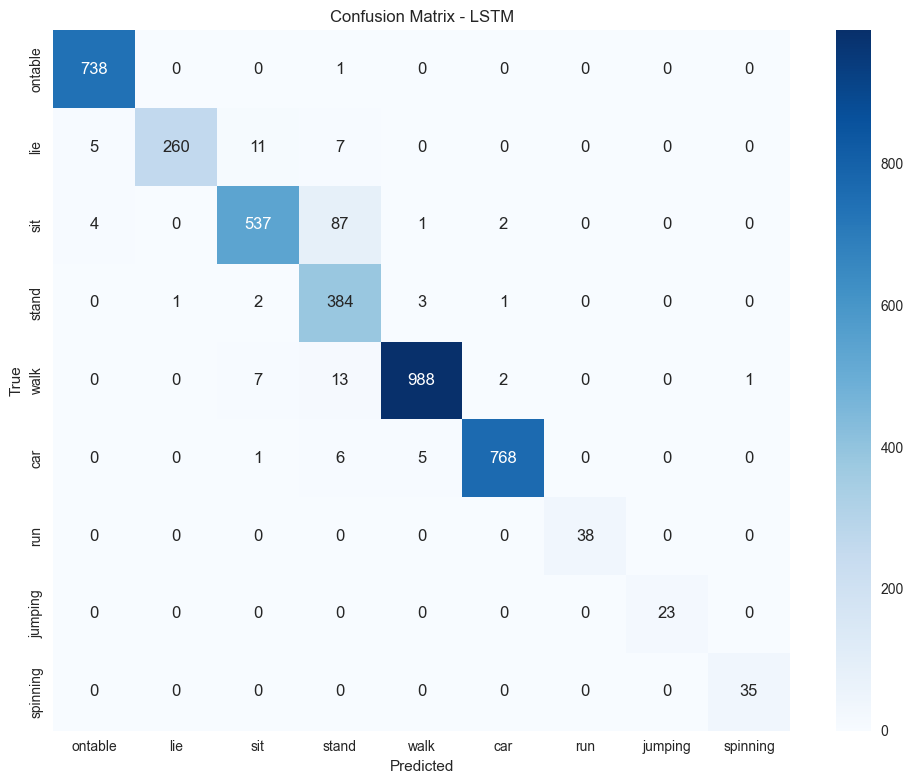

              precision    recall  f1-score   support

     ontable       0.99      1.00      0.99       739
         lie       1.00      0.92      0.96       283
         sit       0.96      0.85      0.90       631
       stand       0.77      0.98      0.86       391
        walk       0.99      0.98      0.98      1011
         car       0.99      0.98      0.99       780
         run       1.00      1.00      1.00        38
     jumping       1.00      1.00      1.00        23
    spinning       0.97      1.00      0.99        35

    accuracy                           0.96      3931
   macro avg       0.96      0.97      0.96      3931
weighted avg       0.96      0.96      0.96      3931

Balanced accuracy: 0.9680408516391673


In [42]:
# Testovanie úspešnosti LSTM modelu na testovacích dátach

y_pred = model.predict(X_test_padded)

target_names = ['ontable', 'lie', 'sit', 'stand', 'walk', 'car', 'run', 'jumping', 'spinning']

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LSTM')
plt.tight_layout()
plt.savefig("confusion_matrix_lstm.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, np.argmax(y_pred, axis=1))}')

In [43]:
# GRU

gru_model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'),
    GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Kompilácia
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Trénovanie
gru_model.fit(X_train_padded, y_train, epochs=200, batch_size=32, verbose=2, validation_data=(X_test_padded, y_test),)

loss, accuracy = gru_model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/200
492/492 - 11s - 23ms/step - accuracy: 0.4281 - loss: 1.5497 - val_accuracy: 0.6304 - val_loss: 1.0604
Epoch 2/200
492/492 - 3s - 7ms/step - accuracy: 0.5765 - loss: 1.1476 - val_accuracy: 0.6825 - val_loss: 0.8576
Epoch 3/200
492/492 - 3s - 7ms/step - accuracy: 0.6213 - loss: 1.0188 - val_accuracy: 0.7085 - val_loss: 0.7833
Epoch 4/200
492/492 - 3s - 7ms/step - accuracy: 0.6504 - loss: 0.9434 - val_accuracy: 0.7268 - val_loss: 0.7136
Epoch 5/200
492/492 - 3s - 7ms/step - accuracy: 0.6702 - loss: 0.8935 - val_accuracy: 0.7504 - val_loss: 0.6679
Epoch 6/200
492/492 - 3s - 7ms/step - accuracy: 0.6820 - loss: 0.8527 - val_accuracy: 0.7820 - val_loss: 0.6155
Epoch 7/200
492/492 - 3s - 7ms/step - accuracy: 0.6994 - loss: 0.8139 - val_accuracy: 0.7479 - val_loss: 0.6449
Epoch 8/200
492/492 - 3s - 6ms/step - accuracy: 0.7043 - loss: 0.7998 - val_accuracy: 0.7525 - val_loss: 0.6379
Epoch 9/200
492/492 - 3s - 7ms/step - accuracy: 0.7054 - loss: 0.7734 - val_accuracy: 0.7688 - val_los

In [44]:
# Export GRU modelu a štruktúry GRU modelu

plot_model(
    gru_model,
    to_file='GRU_feature_architecture.pdf',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    rankdir="TB" # "TB"
)

print("sem export gru modelu")
gru_model.save("my_gru_model.h5")

sem export gru modelu


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


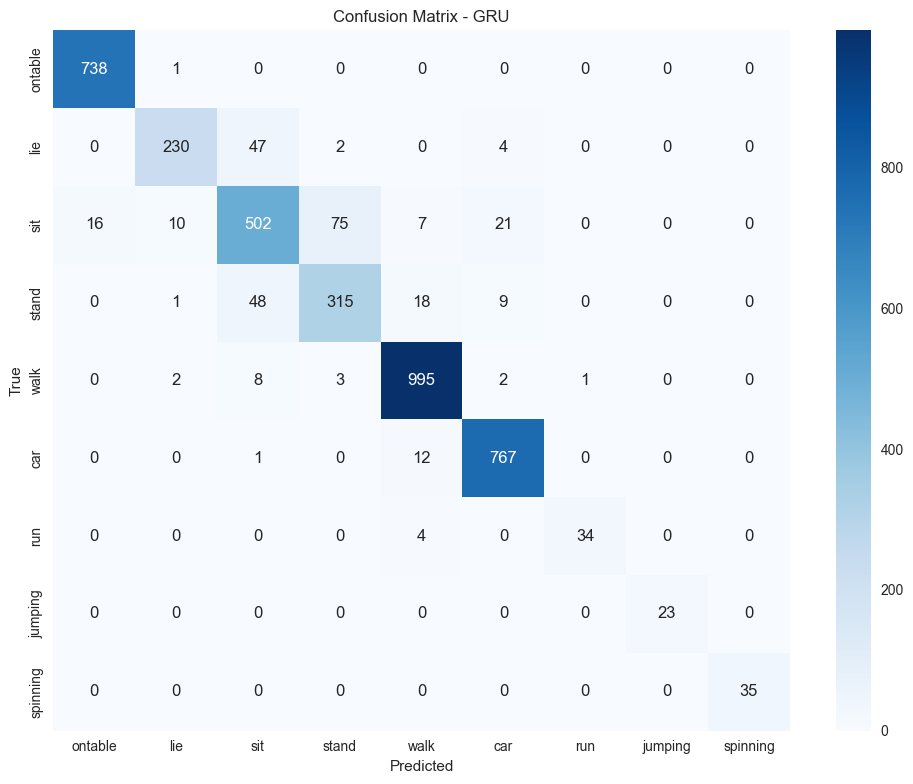

              precision    recall  f1-score   support

     ontable       0.98      1.00      0.99       739
         lie       0.94      0.81      0.87       283
         sit       0.83      0.80      0.81       631
       stand       0.80      0.81      0.80       391
        walk       0.96      0.98      0.97      1011
         car       0.96      0.98      0.97       780
         run       0.97      0.89      0.93        38
     jumping       1.00      1.00      1.00        23
    spinning       1.00      1.00      1.00        35

    accuracy                           0.93      3931
   macro avg       0.94      0.92      0.93      3931
weighted avg       0.92      0.93      0.92      3931

Balanced accuracy: 0.9194223473445658


In [45]:
# Testovanie úspešnosti GRU modelu na testovacích dátach

y_pred = gru_model.predict(X_test_padded)

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GRU')
plt.tight_layout()
plt.savefig("confusion_matrix_gru.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(classification_report(y_test, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, np.argmax(y_pred, axis=1))}')

In [8]:
#TESTOVANIE modelov (v rámci kapitoly testovanie)

from tensorflow.keras.models import load_model

model = load_model('my_lstm_model.h5')
gru_model = load_model('my_gru_model.h5')
raw_model = load_model('raw_data_model.h5')

In [22]:
N_PER_ACT = 60
RNG_SEED = 42

# def pick_n_unique_rows(group: pd.DataFrame, n: int) -> pd.DataFrame:
#     unique_idx = group['index'].unique()

#     n = min(n, len(unique_idx))

#     chosen_idx = (pd.Series(unique_idx).sample(n=n, random_state=RNG_SEED).to_numpy())

#     return group[group['index'].isin(chosen_idx)]

# df_testing = (
#     db_data_nn
#     .groupby('activity', group_keys=False)
#     .apply(pick_n_unique_rows, n=N_PER_ACT)
#     .reset_index(drop=True)
# )

# X_testing, y_testing = prepare_sequences(df_testing)

# X_testing_padded = pad_sequences(X_testing, padding='post', dtype='float32')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


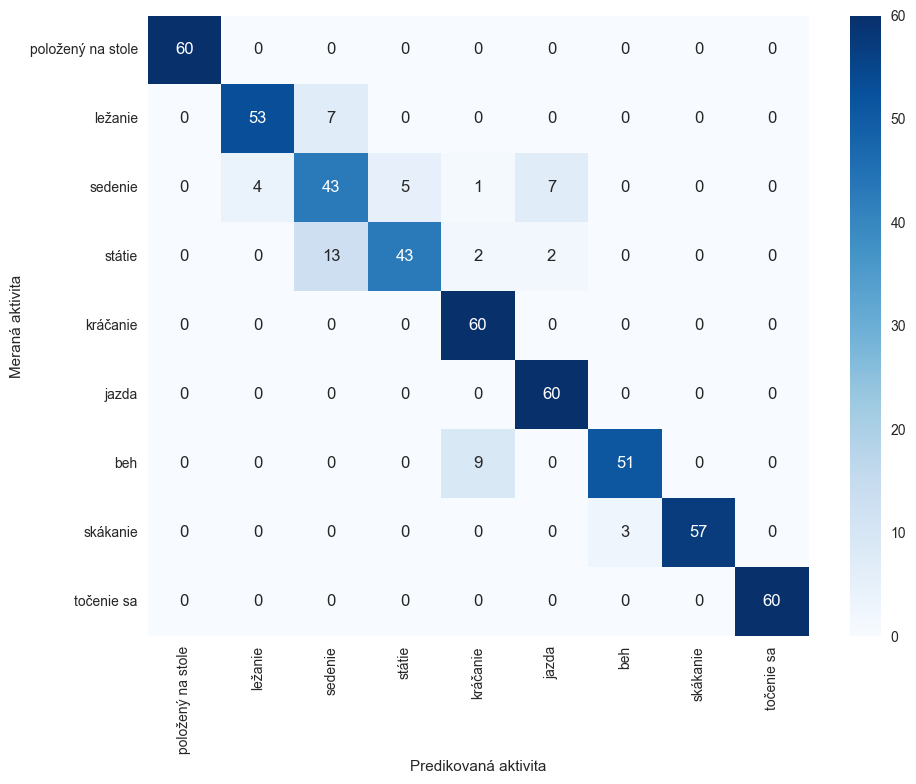

                   precision    recall  f1-score   support

položený na stole       1.00      1.00      1.00        60
          ležanie       0.93      0.88      0.91        60
          sedenie       0.68      0.72      0.70        60
           státie       0.90      0.72      0.80        60
         kráčanie       0.83      1.00      0.91        60
            jazda       0.87      1.00      0.93        60
              beh       0.94      0.85      0.89        60
         skákanie       1.00      0.95      0.97        60
       točenie sa       1.00      1.00      1.00        60

         accuracy                           0.90       540
        macro avg       0.91      0.90      0.90       540
     weighted avg       0.91      0.90      0.90       540

Balanced accuracy: 0.9018518518518519


In [43]:
target_names = ['položený na stole', 'ležanie', 'sedenie', 'státie', 'kráčanie', 'jazda', 'beh', 'skákanie', 'točenie sa']

y_pred = gru_model.predict(X_testing_padded)

cm = confusion_matrix(y_testing, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predikovaná aktivita')
plt.ylabel('Meraná aktivita')
plt.tight_layout()
plt.savefig("confusion_matrix_gru.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(classification_report(y_testing, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y_testing, np.argmax(y_pred, axis=1))}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


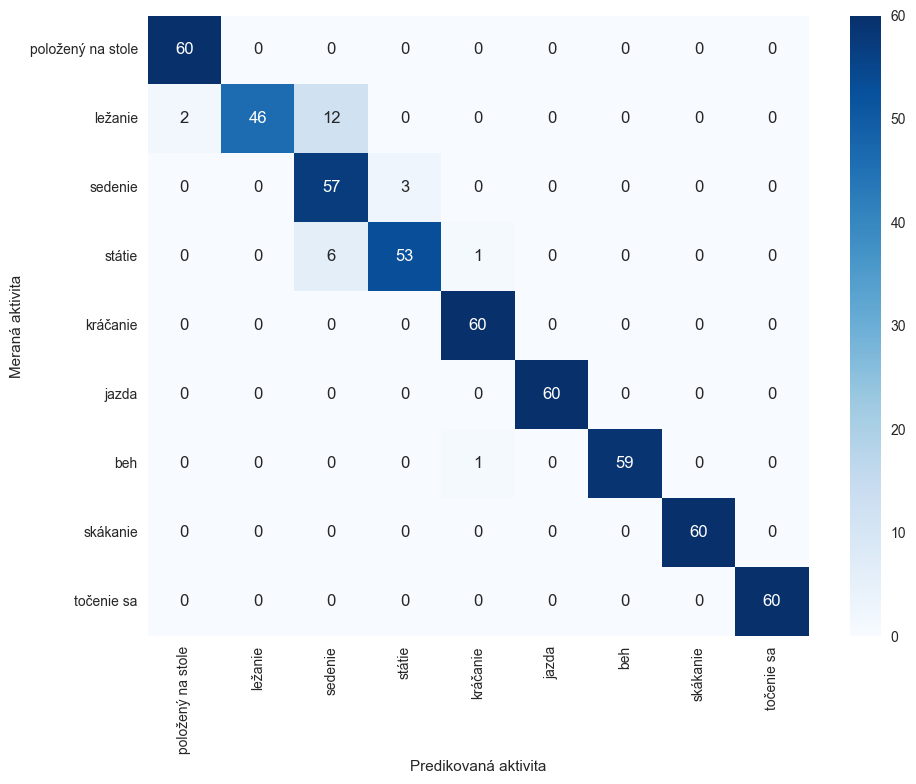

                   precision    recall  f1-score   support

položený na stole       0.97      1.00      0.98        60
          ležanie       1.00      0.77      0.87        60
          sedenie       0.76      0.95      0.84        60
           státie       0.95      0.88      0.91        60
         kráčanie       0.97      1.00      0.98        60
            jazda       1.00      1.00      1.00        60
              beh       1.00      0.98      0.99        60
         skákanie       1.00      1.00      1.00        60
       točenie sa       1.00      1.00      1.00        60

         accuracy                           0.95       540
        macro avg       0.96      0.95      0.95       540
     weighted avg       0.96      0.95      0.95       540

Balanced accuracy: 0.9537037037037036


In [44]:
target_names = ['položený na stole', 'ležanie', 'sedenie', 'státie', 'kráčanie', 'jazda', 'beh', 'skákanie', 'točenie sa']

y_pred = model.predict(X_testing_padded)

cm = confusion_matrix(y_testing, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predikovaná aktivita')
plt.ylabel('Meraná aktivita')
plt.tight_layout()
plt.savefig("confusion_matrix_lstm.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(classification_report(y_testing, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y_testing, np.argmax(y_pred, axis=1))}')

In [23]:
df_raw_testing = (
    results_df_normalized
        .groupby('activity', group_keys=False)        # nerozširuj index o 'activity'
        .apply(lambda g: g.sample(n=N_PER_ACT,
                                  replace=False,
                                  random_state=RNG_SEED))
        .reset_index(drop=True)                       # čisté indexy 0..N-1
)

X_list, y = create_data_arrays(df_raw_testing)

X_padded, lengths = pad_sequences_to_same_length(X_list, pad_value=0.0)

print("X_padded.shape =", X_padded.shape)
print("y.shape =", y.shape)

X_padded.shape = (540, 50, 15)
y.shape = (540,)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


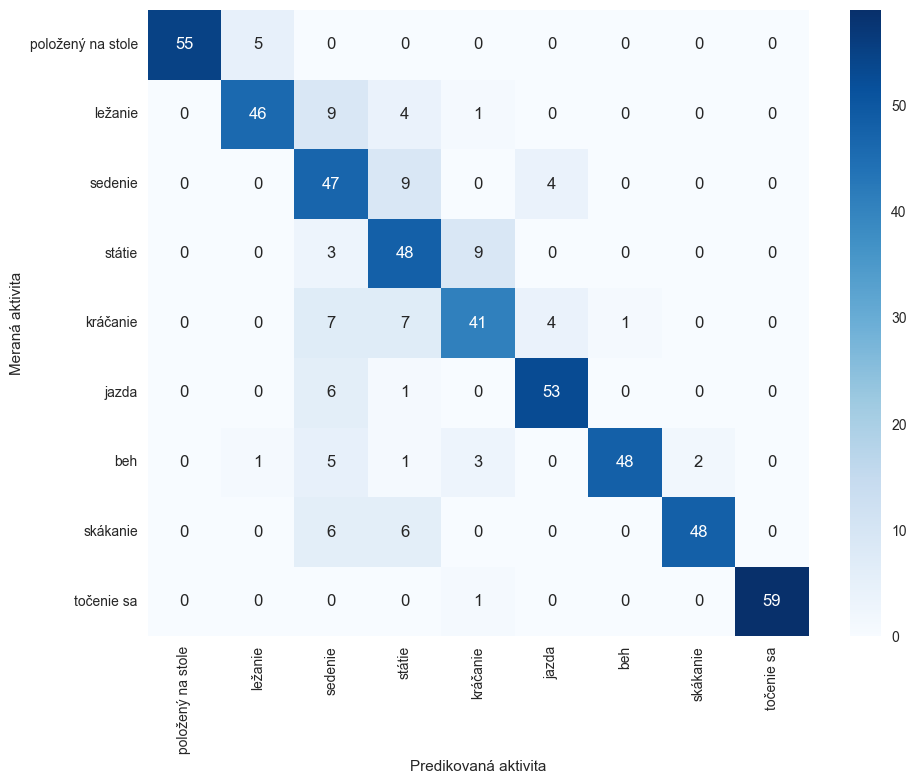

                   precision    recall  f1-score   support

položený na stole       1.00      0.92      0.96        60
          ležanie       0.88      0.77      0.82        60
          sedenie       0.57      0.78      0.66        60
           státie       0.63      0.80      0.71        60
         kráčanie       0.75      0.68      0.71        60
            jazda       0.87      0.88      0.88        60
              beh       0.98      0.80      0.88        60
         skákanie       0.96      0.80      0.87        60
       točenie sa       1.00      0.98      0.99        60

         accuracy                           0.82       540
        macro avg       0.85      0.82      0.83       540
     weighted avg       0.85      0.82      0.83       540

Balanced accuracy: 0.8240740740740741


In [25]:
target_names = ['položený na stole', 'ležanie', 'sedenie', 'státie', 'kráčanie', 'jazda', 'beh', 'skákanie', 'točenie sa']

y_pred = raw_model.predict(X_padded)

cm = confusion_matrix(y, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predikovaná aktivita')
plt.ylabel('Meraná aktivita')
plt.tight_layout()
plt.savefig("confusion_matrix_raw.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(classification_report(y, np.argmax(y_pred, axis=1), target_names=target_names))
print(f'Balanced accuracy: {balanced_accuracy_score(y, np.argmax(y_pred, axis=1))}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


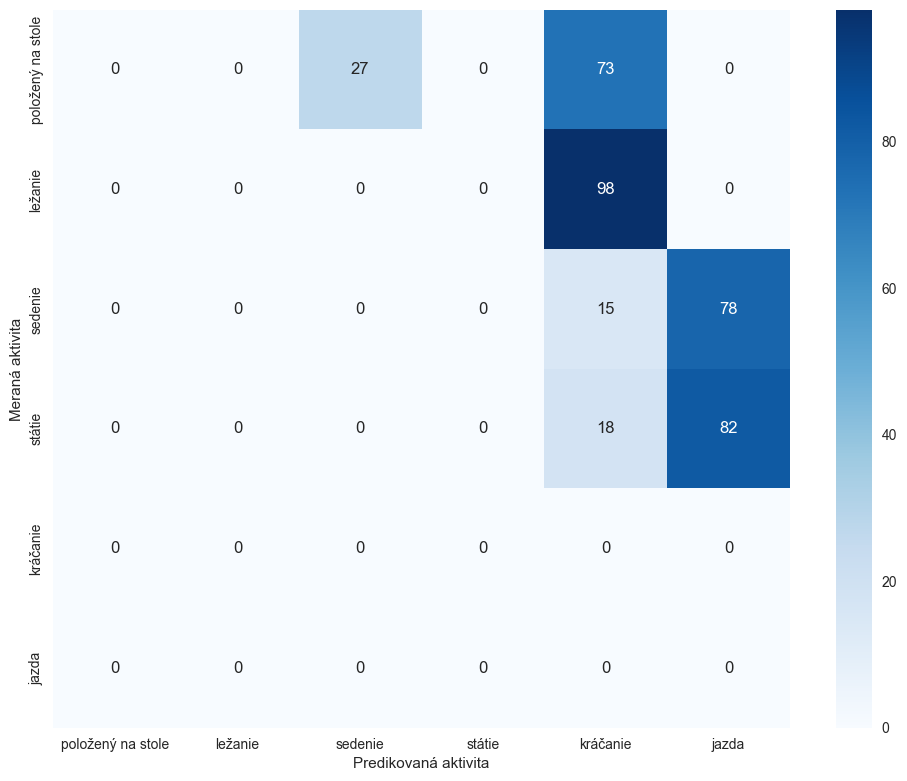

In [17]:
# GENEROVANÉ DÁTA

# Príprava tréningových a testovacích dát
X_test, y_test = prepare_sequences(db_data_nn)

# Padding train na rovnakú dĺžku
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32')


target_names = ['položený na stole', 'ležanie', 'sedenie', 'státie', 'kráčanie', 'jazda']

y_pred = gru_model.predict(X_test_padded)

cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predikovaná aktivita')
plt.ylabel('Meraná aktivita')
plt.tight_layout()
plt.savefig("confusion_matrix_raw.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# pd.set_option('display.max_rows', 250)
# # Zistenie najčastejšej hodnoty a jej počtu
# najcastejsia_hodnota = train_df['index'].value_counts().idxmax()
# pocet_vyskytov = train_df['index'].value_counts().max()

# print(f"Najčastejšia hodnota v stĺpci 'index' je: {najcastejsia_hodnota} a vyskytuje sa {pocet_vyskytov} krát.")

# filtered_df = train_df[train_df['index'] == 701]

# # Zobrazenie výsledného DataFrame
# filtered_df.head(211)

In [10]:
#SPAJANIE DATASETOV

log_file_path = 'data/MHEALTHDATASET/mHealth_subject10.log'

columns = [
    "acc_chest_X", "acc_chest_Y", "acc_chest_Z",
    "ecg_lead_1", "ecg_lead_2",
    "acc_left_ankle_X", "acc_left_ankle_Y", "acc_left_ankle_Z",
    "gyro_left_ankle_X", "gyro_left_ankle_Y", "gyro_left_ankle_Z",
    "mag_left_ankle_X", "mag_left_ankle_Y", "mag_left_ankle_Z",
    "acc_right_arm_X", "acc_right_arm_Y", "acc_right_arm_Z",
    "gyro_right_arm_X", "gyro_right_arm_Y", "gyro_right_arm_Z",
    "mag_right_arm_X", "mag_right_arm_Y", "mag_right_arm_Z",
    "label"
]

df = pd.read_csv(log_file_path, delimiter="\t", names=columns)

# df.head()

# label_counts = df.groupby('label').size().reset_index(name='count')

# label_counts
label_1_rows = df[df['label'] == 3]

# Zobrazenie prvých 5 riadkov
label_1_rows.count()

acc_chest_X          3072
acc_chest_Y          3072
acc_chest_Z          3072
ecg_lead_1           3072
ecg_lead_2           3072
acc_left_ankle_X     3072
acc_left_ankle_Y     3072
acc_left_ankle_Z     3072
gyro_left_ankle_X    3072
gyro_left_ankle_Y    3072
gyro_left_ankle_Z    3072
mag_left_ankle_X     3072
mag_left_ankle_Y     3072
mag_left_ankle_Z     3072
acc_right_arm_X      3072
acc_right_arm_Y      3072
acc_right_arm_Z      3072
gyro_right_arm_X     3072
gyro_right_arm_Y     3072
gyro_right_arm_Z     3072
mag_right_arm_X      3072
mag_right_arm_Y      3072
mag_right_arm_Z      3072
label                3072
dtype: int64

In [44]:
# PAMAP2_Dataset
file_path = 'data/PAMAP2_Dataset/Protocol/subject101.dat'

# Načítanie dát s preskočením nevybraných stĺpcov
columns_to_use = [0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # indexované od nuly
column_names = [
    'timestamp', 'label',
    'acc_x_1', 'acc_y_1', 'acc_z_1',
    'acc_x_2', 'acc_y_2', 'acc_z_2',
    'gyro_x', 'gyro_y', 'gyro_z',
]

# Načítanie dát do DataFrame
df = pd.read_csv(file_path, sep=' ', header=None, usecols=columns_to_use, names=column_names)

# Zobrazenie hlavičky výsledného DataFrame
df.head()

label_counts = df.groupby('label').size().reset_index(name='count')

# label_counts
label_1_rows = df[df['label'] == 1]
label_1_rows

def check_timestamp_increment(df, timestamp_col, increment=0.01, tolerance=1e-5):
    # Rozdiely medzi timestampmi
    differences = df[timestamp_col].diff().dropna()  # diff() vypočíta rozdiely medzi susednými hodnotami
    
    if np.allclose(differences, increment, atol=tolerance):
        print(f"Timestamp values are consistent with the increment of {increment}.")
        return True
    else:
        inconsistent_rows = differences[~np.allclose(differences, increment, atol=tolerance)]
        print(f"Inconsistencies found in the timestamp increments.")
        print(f"Inconsistent rows (with differences):\n{inconsistent_rows}")
        return False

# Testovanie dataset
# df = pd.DataFrame({
#     "timestamp": [37.66, 37.67, 37.68, 37.69, 37.70]
# })
    
check_timestamp_increment(df, timestamp_col="timestamp", increment=0.01)
label_1_rows

Timestamp values are consistent with the increment of 0.01.


,timestamp,label,acc_x_1,acc_y_1,acc_z_1,acc_x_2,acc_y_2,acc_z_2,gyro_x,gyro_y,gyro_z
2928,37.66,1,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.975500
2929,37.67,1,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.909100
2930,37.68,1,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.508300
2931,37.69,1,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.560200
2932,37.70,1,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.085700
...,...,...,...,...,...,...,...,...,...,...,...
30110,309.48,1,2.27595,9.38169,2.99104,0.146732,-0.010934,0.012664,15.34250,-67.0271,-0.828196
30111,309.49,1,2.27519,9.27599,3.00638,0.115042,-0.038663,-0.002015,14.89380,-67.5452,-0.828641
30112,309.50,1,2.34966,9.18483,2.99140,0.107719,-0.014148,0.012051,15.35620,-67.0369,-0.134086
30113,309.51,1,2.42488,9.13900,3.02162,0.097379,-0.004847,0.022243,15.10650,-67.3325,-1.407430
